# <a id='toc1_'></a>[Synergy Transfer](#toc0_)

Author: Blake McBride<br>
Email: blakepm2@illinois.edu<br>
Course: CS 590 Deep Learning for Healthcare<br>
Professor: Jimeng Sun<br>

This notebook presents the reproduction results for the paper **"Anticancer drug synergy prediction in understudied tisues using transfer learning"** ([Kim et al. 2020](https://doi.org/10.1101/2020.02.05.932657)). All major code components have been reused and adapted from the work of the original authors, with modifications made for reproduction purposes.

The original publication can be accessed [here](https://academic.oup.com/jamia/article-abstract/28/1/42/5920819?redirectedFrom=fulltext&login=false).

The original publication GitHub repoitory can be accessed [here](https://github.com/yejinjkim/synergy-transfer).

The public GitHub repository for this project can be accessed [here](https://github.com/blakepm2/synergy_transfer)

## <a id='toc1_1_'></a>[Table of Contents](#toc0_)

 - [Synergy Transfer](#toc1_)    
  - [Table of Contents](#toc1_1_)    
  - [Introduction](#toc1_2_)    
  - [Scope of Reproducability](#toc1_3_)    
    - [A Note on Previous Work: MoleculeSTM](#toc1_3_1_)    
      - [Environment Complexity](#toc1_3_1_1_)    
      - [Computational Limitations](#toc1_3_1_2_)    
    - [Switching to Synergy Transfer](#toc1_3_2_)    
      - [Absences and Misalignments in Data](#toc1_3_2_1_)    
  - [Methodology](#toc1_4_)    
    - [Environment](#toc1_4_1_)    
      - [Conda](#toc1_4_1_1_)    
      - [Python Dependencies](#toc1_4_1_2_)    
    - [Data](#toc1_4_2_)    
      - [Sources](#toc1_4_2_1_)    
      - [Configuration](#toc1_4_2_2_)    
      - [Download](#toc1_4_2_3_)    
      - [Summary](#toc1_4_2_4_)    
        - [Data Exploration](#toc1_4_2_4_1_)    
        - [Transforming Items to ID](#toc1_4_2_4_2_)    
      - [Drugs](#toc1_4_2_5_)    
        - [Preprocessing](#toc1_4_2_5_1_)    
        - [Aligning Drug's Target Gene(s)](#toc1_4_2_5_2_)    
      - [Cells](#toc1_4_2_6_)    
        - [Preprocessing](#toc1_4_2_6_1_)    
        - [Aligning Cell Lines with Gene Expression(s)](#toc1_4_2_6_2_)    
        - [Gene Integration](#toc1_4_2_6_3_)    
        - [Data Exploration](#toc1_4_2_6_4_)    
    - [Model](#toc1_4_3_)    
      - [Architecture](#toc1_4_3_1_)    
        - [Drug Encoder](#toc1_4_3_1_1_)    
        - [Cell Line Encoder](#toc1_4_3_1_2_)    
        - [Merging Layers](#toc1_4_3_1_3_)    
      - [Configuration](#toc1_4_3_2_)    
      - [Gene Compression](#toc1_4_3_3_)    
        - [Dataset and Dataloader](#toc1_4_3_3_1_)    
        - [Compress gene features](#toc1_4_3_3_2_)    
      - [Synergy prediction](#toc1_4_3_4_)    
        - [Train/test split in cross or external validation](#toc1_4_3_4_1_)    
        - [Dataset and Dataloader](#toc1_4_3_4_2_)    
        - [Load dataset](#toc1_4_3_4_3_)    
      - [Prediction model](#toc1_4_3_5_)    
      - [Training](#toc1_4_3_6_)    
        - [Hyperparameters](#toc1_4_3_6_1_)    
        - [Computational Requirements](#toc1_4_3_6_2_)    
      - [Evaluation](#toc1_4_3_7_)    
        - [Evaluation Metrics](#toc1_4_3_7_1_)    
      - [Train Specific Model](#toc1_4_3_8_)    
        - [Freeze layers](#toc1_4_3_8_1_)    
      - [Evaluate Specific Model](#toc1_4_3_9_)    
        - [Select the top ranked drug combinations](#toc1_4_3_9_1_)    
  - [Results](#toc1_5_)    
    - [Drug response prediction accuracy for data-rich tissues](#toc1_5_1_)    
    - [Drug response prediction accuracy for bone and prostate cancer](#toc1_5_2_)    
    - [Ranking Predicted Synergenistic Drug Combinations](#toc1_5_3_)    
      - [Prostate Top Predictions](#toc1_5_3_1_)    
      - [Bone Top Predictions](#toc1_5_3_2_)    
  - [Discussion](#toc1_6_)    
    - [Issues Encountered](#toc1_6_1_)    
    - [Reproducability and Future Considerations](#toc1_6_2_)    
  - [References](#toc1_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_2_'></a>[Introduction](#toc0_)

In the pursuit of enhancing the efficacy of cancer treatments, the exploration of synergistic drug combinations has emerged as a promising strategy. Indeed, Kim et al. demonstrate in their paper how high-throughput combinatorial drug screening offers a pathway to discover these potent combinations, leveraging the complex interplay between multiple drugs to achieve higher efficacy without compromising safety ([Kim et al. 2020](https://doi.org/10.1101/2020.02.05.932657)). Whereas traditional drug discovery processes are not only costly and time-consuming but often result in therapies that target single molecules or pathways, potentially missing opportunities for enhanced therapeutic effects through drug combinations.

A significant challenge in this domain is the uneven distribution of data across various cancer types. While some cancers have been extensively studied, providing a rich dataset of drug responses, others, such as bone and prostate cancers, remain understudied due to various obstacles including the difficulty in obtaining viable cell lines and the complexity of their in-vitro models ([Kim et al. 2020](https://doi.org/10.1101/2020.02.05.932657)). This disparity poses a problem for developing effective treatments for these less-studied tissues, as the lack of data hampers the predictive power of drug response models. Addressing this issue, Kim et al. present a novel approach to predicting effective drug combinations in tissues with scant data. By employing **transfer learning**, the study leverages the abundance of data from well-studied tissues to enhance predictions in data-poor tissues, thus overcoming a significant hurdle in cancer treatment research. The methodology centers around the development of a deep neural network model that integrates a comprehensive set of genetic, molecular, and phenotypic features collected from various databases. This model not only predicts drug synergy but also adapts the knowledge learned from data-rich contexts to those that are data-deficient.

The core innovation of this study lies in its use of transfer learning, a technique where a model developed for one task is reused as the starting point for a model on a second task. Here, it involves transferring the insights gained from drug-cell interactions in common cancers to improve synergy predictions in less common ones. This approach is particularly advantageous in dealing with the sparse data scenarios typical of understudied tissues. By doing so, the model provides a means to prioritize future in-vitro experiments, potentially accelerating the discovery of viable cancer treatments for these challenging cases.

The work of Kim et al. significantly contributes to the field of computational drug discovery by demonstrating how advanced machine learning techniques can bridge the gap between data-rich and data-poor scenarios. This not only enhances the predictive accuracy of drug synergy models but also broadens the scope of their applicability to a wider range of tissues, ultimately facilitating more targeted and effective cancer treatments.

## <a id='toc1_3_'></a>[Scope of Reproducability](#toc0_)

In terms of the reproducability of this paper, I encountered several issues while attempting to reproduce the authors' results ([Kim et al. 2020](https://doi.org/10.1101/2020.02.05.932657)). I should make note here that this has been a consistent issue I've faced throughout the course of this project, as this is the 2nd project that I've attempted. To demonstrate the sincere efforts that have been put into this project without being able to showcase any final results, I will detail my process here.

### <a id='toc1_3_1_'></a>[A Note on Previous Work: MoleculeSTM](#toc0_)

Originally, I chose to reproduce the results of [Chao et al. (2023)](https://doi.org/10.1038/s42256-023-00759-6) for my assignment. In their work, Chao et al. premiered MoleculeSTM, a multi-modal molecule structure-text model for text-based retrieval and editing. The goal of their work was to showcase a new machine learning approach for drug discovery that, in separation from other work in this domain, would jointly learn molecules chemical structures as well as their textual descriptions through a contrastive learning approach ([Chao et al. 2023](https://doi.org/10.1038/s42256-023-00759-6)). I was unable to reproduce the results of this paper for two primary reasons: the complexity of environmental dependencies, and the computational feasibility.

#### <a id='toc1_3_1_1_'></a>[Environment Complexity](#toc0_)

Regarding the environment setup process, this proved to be very taxing and took nearly a week to successfully complete. This seems to stem from a dependency conflict between some of the packages used, namely between PyTorch, CUDA, and Apex. I tried to configure the environment on three different operating systems; starting with Windows 11, then MacOS Sonoma, and finally Ubuntu 22.04. I reached out to ShangChao Liu for support and his advice was to set the environment up on Linux, so I partitioned my hard drive and installed Ubuntu, at which point I was able to get through the environment setup successfully. Additionally, after noticing that others were experiencing similar difficulties with the environment setup, I recieved permission from Dr. Liu to make a pull request to the respository with my fix, which explicitly set a compatible version of CUDA binaries to be installed with the PyTorch installation. 

#### <a id='toc1_3_1_2_'></a>[Computational Limitations](#toc0_)

The second issue that made this paper difficult to reproduce within the scope of this project was the computational feasibility. Using an NVIDIA GTX 4090 GPU, I successfully started the pretraining process on Friday, April 12th, and left it running for 2 weeks. I started having concerns after seeing minimal progress the next morning, so I started researching alternative papers from a collection of backups that I kept. After letting the pretraining process run, I was disheartened to see that only 30/100 epochs had completed. I again reached out to Dr. Liu for guidance and he informed me that he and his colleagues originally trained MoleculeSTM on a computing cluster of multiple machines each outfitted with several CPUs and at least 4 NVIDIA 2080 GPUs. This was not a realistic or feasible paper for me to reproduce in time for submission without spending a significant amount of money on accessing higher-powered computing space. Unfortunately, without realizing how long the pretraining process was estimated to take, I neglected to add code to save checkpoints as it went along, which means that after terminating the process I had nothing to show for this. 

### <a id='toc1_3_2_'></a>[Switching to Synergy Transfer](#toc0_)

Deciding to switch projects to one that would be more feasible required me to examine my backup papers for one that had a lower computational complexity and had readily accessible data, as I did not anticipate a need to request access to any of the MIMIC data given that MoleculeSTM had its data stored in HuggingFace repositories. To this end, I landed on Synergy Transfer by [Kim et al. (2020)](https://doi.org/10.1101/2020.02.05.932657), which seemed promising due to its comparatively lower system requirements and open source data usage. 

#### <a id='toc1_3_2_1_'></a>[Absences and Misalignments in Data](#toc0_)

While my shift from MoleculeSTM to Synergy Transfer was done primarily for its use of publicly available data, I quickly found that this was a significant challenge due to the unavailability of some of the original data used and the lack of documentation for acquiring it or replicating their findings. Without documentation of any kind, I followed the only indications I had from the original paper as well as the GitHub repo, which stated that data had been accessed from DrugComb and DrugBank. It took time to understand how to acquire the data using the API from DrugComb, but once I did manage to get the data I noticed that there had been significant changes to the data architecture since this paper was firts published. Specifically, key dimensions reflecting the tissue and disease names, as well as the synergy scores for various blocks were absent from the new version of data available on DrugComb. I refactored the code as best as I could to align with the new dimensionality, but there were still issues with the absence of tissue and disease names that caused downsteam errors in the Synergy Prediction task, as will be seen in future sections. 

Where DrugBank was concerned, I had no realistic pathway to help me acquire it, so I similarly decided to reach out to two of the original authors of the paper, Kim Yejin and Jing Tang, for guidance. Kim Yejin shared with me a .zip file containing some of the data used for downstream tasks in the preprocessing notebook, but it was not inclusive of all of the original data they used. When I requested all of the original data used, she did not respond. Jing Tang shared the original summary .csv file that I was looking for, but the dimensionality of this data did not match the newer version or the version that they used in the original paper, so I was still blocked from fully realizing their results.

## <a id='toc1_4_'></a>[Methodology](#toc0_)

This section will cover the methodology used for reproducing the results of [Kim et al. (2020)](https://doi.org/10.1101/2020.02.05.932657), including a full setup guide for the environment, an overview of available data, the model architecture, training process, and evaluation. 

### <a id='toc1_4_1_'></a>[Environment](#toc0_)

Before beginning the environment setup, I should note that I used a machine with Ubuntu v22.04 installed and would recommend doing the same to avoid some complexity with package installation. Assuming you're working on some distribution of Linux or want to attempt the setup with a different OS, the first step is to install Conda.

#### <a id='toc1_4_1_1_'></a>[Conda](#toc0_)

First, install Conda as shown below, you can refer to more comprehensive instructions on [Conda's website](https://docs.conda.io/projects/conda/en/latest/user-guide/install/linux.html) if you're using a different OS.

```
mkdir -p ~/miniconda3
wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O ~/miniconda3/miniconda.sh
bash ~/miniconda3/miniconda.sh -b -u -p ~/miniconda3
rm -rf ~/miniconda3/miniconda.sh
```

Then initialize bash and zsh shells

```
~/miniconda3/bin/conda init bash
~/miniconda3/bin/conda init zsh
```

Create a new conda environment using **Python 3.8** as the base. To make things easier, you can use the following command to create a new conda environment using the [environment.yaml](environment.yaml) file, as shown below:

```
conda env create -f environment.yaml
```

Or, if you wish to do it yourself, create your new conda environment as shown below:

```
conda create -n synergy python=3.8
```

and activate it

```
conda activate synergy
```

#### <a id='toc1_4_1_2_'></a>[Python Dependencies](#toc0_)

With a conda environment successfully configured, you now must install all of the required Python dependencies.

```
pip install torch torchvision
pip install cudatoolkit==12.1
pip install pandas
pip install scikit-learn
pip install seaborn
pip install numpy
pip install matplotlib
pip install rdkit
```

At this point you should be all set up to start running the code in this notebook. Ensure you select the conda environment you created as the Kernel.

### <a id='toc1_4_2_'></a>[Data](#toc0_)

Once the environment has been successfully configured, the next step is accessing and preprocessing the data. The section below provides download instructions for all of the data used for this project (both raw and processed). You can run the code below to perform all preprocessing steps manually, or you can simply use the provided processed data used for model training and evaluation.

#### <a id='toc1_4_2_1_'></a>[Sources](#toc0_)

The data used for this analysis comes from 4 different sources: 

- **DrugComb**

    - For drug sensitivity and synergy data [(Zagidullin et al. 2019)](https://doi.org/10.1093/nar/gkz337)

- **DrugBank**

    - For drug genomic features [(Wishart et al. 2007)](https://doi.org/10.1093/nar/gkm958)

- **Therapeutic Targets Database (TTD)**

    - For drug genomic features [(Chen et al. 2002)](https://doi.org/10.1093/nar/30.1.412)

- **NIH-LINC**

    - For drug genomic features [(Harvard Medical School 2017)](http://lincsportal.ccs.miami.edu/datasets/#/view/LDS-1415)

#### <a id='toc1_4_2_2_'></a>[Configuration](#toc0_)

Import required modules

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import rdkit
from rdkit import Chem
from rdkit.Chem import MACCSkeys
import re
import seaborn as sns
from matplotlib.colors import LogNorm
import math
import gdown
import os

from utilities import Mapping

Set your data path as the directory in which you saved the downloaded data

In [2]:
DATA_PATH = 'synergy_transfer_data/'

#### <a id='toc1_4_2_3_'></a>[Download](#toc0_)

Run the code below to download all of the data to your data path

In [3]:
gdown.download_folder('https://drive.google.com/drive/u/1/folders/14xZ4BLGMEO0Wv5uY0R2tMtB13hevjVLF', quiet=False)

Retrieving folder contents


Retrieving folder 1tJjbItceWewAFKT6GbkiEc0uetG9v66Y cell
Retrieving folder 1McFcm50uxfOhSLdV32mpwi1y64WEbyLl processed
Processing file 1wn6X6CKzBorf74qYfj299kGjcQh6qcC- cell_features.p
Retrieving folder 1DFpAvjQkXsSeR-AQwQZJ_ZQWXMh7Udfn raw
Processing file 1vHCitsb1wwjZpb5d5Oph6zefuOImINP1 cell_line_meta.csv
Processing file 1WEhqtuSDjZgPAqFBdcYY8d1-pUqY_96s cell_lines.csv
Retrieving folder 1NXmg7tbKZP2anOXrJ4dhDbIToFiHUDrx drug
Retrieving folder 1uZutTWVUKDwYlkBQTDvCTwRnIKOQeO4s processed
Processing file 1OQYj57LwSqJgRXNLHwCeLIo_4E_6g9kW drug_clean_fp.p
Processing file 1TZ1v9l4GIQO8fchQPJFEpZHs-Q0LvaP9 drug_clean.csv
Processing file 1ZO-Tzwxz1lUYU8RuhWu3G5ZHYwI32cQm drug_features.p
Retrieving folder 1DX9dWJPOq3IzyELCH719FXGN92Rjddah raw
Processing file 18mZ8ywSYDuUNgeG03YSpznvwdeA68xcy drug_DrugBank_target.csv
Processing file 1rIs8Mlm9BJQCyWI1l0QT9h9bn4AdZvsc drug_lincs_target.csv
Processing file 1ItbIrk0bpqGEIdfv1S_DC8wUg4I6tasX drug_TTD_target.csv
Processing file 1BwIuZb2JhBs07lPOEtg

Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1wn6X6CKzBorf74qYfj299kGjcQh6qcC-
To: /home/blake/synergy_transfer/synergy_transfer_data/cell/processed/cell_features.p
100%|██████████| 43.7M/43.7M [00:01<00:00, 27.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vHCitsb1wwjZpb5d5Oph6zefuOImINP1
To: /home/blake/synergy_transfer/synergy_transfer_data/cell/raw/cell_line_meta.csv
100%|██████████| 256k/256k [00:00<00:00, 6.59MB/s]
Downloading...
From: https://drive.google.com/uc?id=1WEhqtuSDjZgPAqFBdcYY8d1-pUqY_96s
To: /home/blake/synergy_transfer/synergy_transfer_data/cell/raw/cell_lines.csv
100%|██████████| 259k/259k [00:00<00:00, 7.73MB/s]
Downloading...
From: https://drive.google.com/uc?id=1OQYj57LwSqJgRXNLHwCeLIo_4E_6g9kW
To: /home/blake/synergy_transfer/synergy_transfer_data/drug/processed/drug_clean_fp.p
100%|██████████| 2.29M/2.29M [00:00<00:00, 16.3MB/s]
Downloadi

['/home/blake/synergy_transfer/synergy_transfer_data/cell/processed/cell_features.p',
 '/home/blake/synergy_transfer/synergy_transfer_data/cell/raw/cell_line_meta.csv',
 '/home/blake/synergy_transfer/synergy_transfer_data/cell/raw/cell_lines.csv',
 '/home/blake/synergy_transfer/synergy_transfer_data/drug/processed/drug_clean_fp.p',
 '/home/blake/synergy_transfer/synergy_transfer_data/drug/processed/drug_clean.csv',
 '/home/blake/synergy_transfer/synergy_transfer_data/drug/processed/drug_features.p',
 '/home/blake/synergy_transfer/synergy_transfer_data/drug/raw/drug_DrugBank_target.csv',
 '/home/blake/synergy_transfer/synergy_transfer_data/drug/raw/drug_lincs_target.csv',
 '/home/blake/synergy_transfer/synergy_transfer_data/drug/raw/drug_TTD_target.csv',
 '/home/blake/synergy_transfer/synergy_transfer_data/drug/raw/drugs.csv',
 '/home/blake/synergy_transfer/synergy_transfer_data/gene/raw/fpkm_broad.csv',
 '/home/blake/synergy_transfer/synergy_transfer_data/gene/raw/fpkm_sangar.csv',
 '/

#### <a id='toc1_4_2_4_'></a>[Summary](#toc0_)

The first dataset we use is the `summary_table` dataset. This dataset serves as a source for drug and cell_lines information, as well as ids corresponding to various healthcare data sources for joining this information with supplementary data, as we will see later.

First, load in the summary

In [4]:
summary = pd.read_csv(f'{DATA_PATH}/summary/raw/summary_table.csv')

/tmp/ipykernel_147898/107560680.py:1: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  summary = pd.read_csv(f'{DATA_PATH}/summary/raw/summary_table.csv')


Take the average of replicates experiments

In [5]:
summary_mean = summary.groupby(['drug_row','drug_col','cell_line_name', 'study_id'], 
                               as_index=False).mean(numeric_only=True)

summary_mean = summary_mean.loc[:, ['drug_row', 'drug_col', 'cell_line_name', 'study_id','ri_row', 'ri_col', 'synergy_loewe']]

##### <a id='toc1_4_2_4_1_'></a>[Data Exploration](#toc0_)

Determine the Monotherapy Sensitivity

In [6]:
sensitivity = pd.concat([
          summary_mean.loc[:, ['drug_row', 'cell_line_name', 'ri_row']].rename(columns={'drug_row':'drug', 'ri_row':'ri'}),
          summary_mean.loc[:, ['drug_col', 'cell_line_name', 'ri_col']].rename(columns={'drug_col':'drug', 'ri_col':'ri'})
        ])

Plot Relative Inhibition vs Loewe Synergy

Text(0, 0.5, 'Counts')

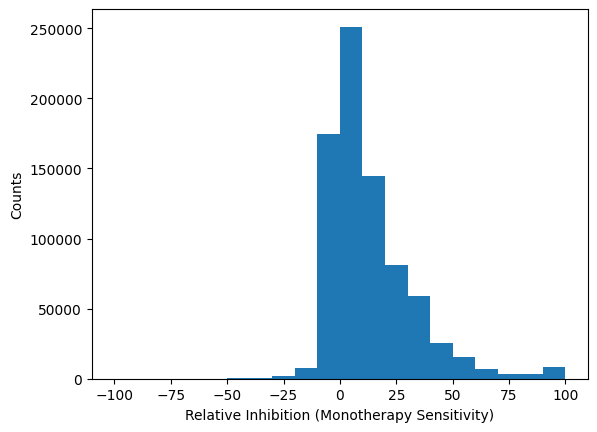

In [7]:
plt.hist(sensitivity['ri'], bins=20, range=[-100,100])
plt.xlabel("Relative Inhibition (Monotherapy Sensitivity)")
plt.ylabel("Counts")
#plt.savefig(data_path+'ri_cnt.png',  bbox_inches='tight', dpi=200)

Text(0, 0.5, 'Counts')

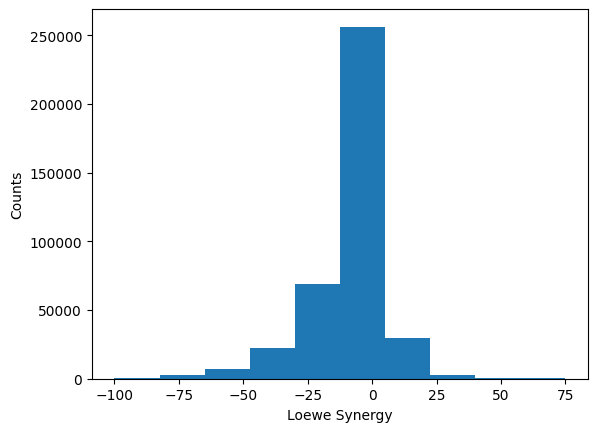

In [8]:
plt.hist(((summary_mean.loc[:,'synergy_loewe'].values.reshape(-1))), range=[-100, 75])
plt.xlabel("Loewe Synergy")
plt.ylabel("Counts")
#plt.savefig(data_path+'syn_cnt.png', bbox_inches='tight', dpi=200)

(-100.0, 100.0)

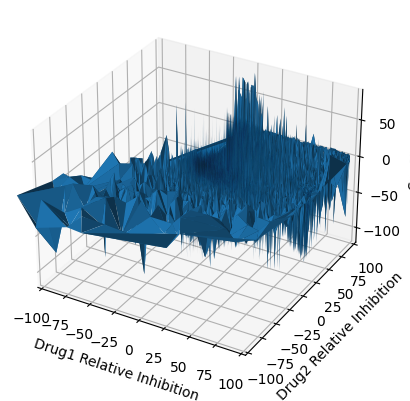

In [9]:
X = summary_mean.loc[:,'ri_row'].to_numpy()
Y = summary_mean.loc[:,'ri_col'].to_numpy()
Z = summary_mean.loc[:,'synergy_loewe'].to_numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(X,Y,Z)

ax.set_xlabel('Drug1 Relative Inhibition')
ax.set_ylabel('Drug2 Relative Inhibition')
ax.set_zlabel('Synergy')
ax.set_xlim(-100, 100)
ax.set_ylim(-100, 100)

# fig.savefig(data_path+'ri_synergy_3d.png', dpi=200)

##### <a id='toc1_4_2_4_2_'></a>[Transforming Items to ID](#toc0_)

We leverage the `Mapping` class to map items to indices and update the datasets to ensure consistency across all of the data

In [10]:
codes = {
    'drugs': Mapping(set(summary_mean['drug_row'].unique()).union(set(summary_mean['drug_col'].unique()))),
    'cell':Mapping(summary_mean['cell_line_name'].unique())
    }

In [11]:
summary_mean['drug_col'] = summary_mean['drug_col'].apply(lambda x: codes['drugs'].item2idx[x])
summary_mean['drug_row'] = summary_mean['drug_row'].apply(lambda x: codes['drugs'].item2idx[x])
summary_mean['cell_line_name'] = summary_mean['cell_line_name'].apply(lambda x: codes['cell'].item2idx[x])

In [12]:
summary_mean.head()

,drug_row,drug_col,cell_line_name,study_id,ri_row,ri_col,synergy_loewe
0,3528,3467,0,4.0,-21.0794,17.392589,4.436431
1,702,2554,1,6.0,-20.0430,25.595000,-44.555935
2,702,2003,1,6.0,-9.7760,29.111000,-37.189720
3,2554,2554,2,12.0,6.7970,6.964000,1.283298
4,2554,2554,3,12.0,11.5280,7.190000,-3.028745


Save the updated summary

In [13]:
summary_mean.to_pickle(f'{DATA_PATH}/summary/processed/summary_mean.p')

#### <a id='toc1_4_2_5_'></a>[Drugs](#toc0_)

Next, we look at the data for `drugs`. This data includes various drug features and molecular structures to learn the model and help it make synergy predictions.

Load in the data

In [14]:
drug = pd.read_csv(f'{DATA_PATH}/drug/raw/drugs.csv')

##### <a id='toc1_4_2_5_1_'></a>[Preprocessing](#toc0_)

We apply our mapping and perform some error correction for certain smiles in the dataset

In [15]:
drug['id']=drug['dname'].apply(lambda x: codes['drugs'].item2idx.get(x))
drug = drug.loc[~drug['id'].isna(),:]

drug.loc[drug['cid']==57519530,'smiles']='CC(C)CC1C(=O)NC(C(=O)NC(CCCC=CCCCCCCC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)N1)CCCNC(=N)N)CC2=CNC3=CC=CC=C32)CC(C)C)CC(=O)N)(C)NC(=O)C(CC4=CC=CC=C4)NC(=O)C(C(C)O)NC(=O)C(CCC(=O)N)NC(=O)C(CCC(=O)N)NC(=O)C(CO)NC(=O)C(CCC(=O)N)NC(=O)CCNC(=O)C)(C)C(=O)NC(CCC(=O)N)C(=O)NC(CC(=O)N)C(=O)N)CC(C)C'
drug.loc[drug['cid']==73265323,'smiles']='CC(C)CCCCCCCC(=O)NC1C(C(C(OC1OC2=C3C=C4C=C2OC5=C(C=C(C=C5)C(C6C(=O)NC(C7=C(C(=CC(=C7)O)OC8C(C(C(C(O8)CO)O)O)O)C9=C(C=CC(=C9)C(C(=O)N6)NC(=O)C4NC(=O)C1C2=CC(=CC(=C2)OC2=C(C=CC(=C2)C(C(=O)NC(CC2=CC(=C(O3)C=C2)Cl)C(=O)N1)N)O)O)O)C(=O)O)OC1C(C(C(C(O1)CO)O)O)NC(=O)C)Cl)CO)O)O'
drug.loc[drug['cid']==16131923,'smiles']='CCCCCCCCCC(=O)NC1C(C(C(OC1OC2=C3C=C4C=C2OC5=C(C=C(C=C5)C(C6C(=O)NC(C7=C(C(=CC(=C7)O)OC8C(C(C(C(O8)CO)O)O)O)C9=C(C=CC(=C9)C(C(=O)N6)NC(=O)C4NC(=O)C1C2=CC(=CC(=C2)OC2=C(C=CC(=C2)C(C(=O)NC(CC2=CC(=C(O3)C=C2)Cl)C(=O)N1)N)O)O)O)C(=O)O)OC1C(C(C(C(O1)CO)O)O)NC(=O)C)Cl)CO)O)O'

drug.to_csv(f'{DATA_PATH}/drug/processed/drug_clean.csv', index=False)

Get the MAACS fingerprint from the smiles for numeric representations

In [16]:
drug = pd.read_csv(f'{DATA_PATH}/drug/processed/drug_clean.csv')
drug['fps']=drug['smiles'].apply(lambda x: list(MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x))) if Chem.MolFromSmiles(x) is not None else '')

drug.to_pickle(f'{DATA_PATH}/drug/processed/drug_clean_fp.p')

In [17]:
drug = pickle.load(open(f'{DATA_PATH}/drug/processed/drug_clean_fp.p', 'rb'))
drug['id'] = drug['id'].apply(lambda x: int(x))

In [18]:
drug.head(10)

,dname,chembl_id,inchikey,smiles,cid,molecular_formula,clinical_phase,cid_m,cid_s,stitch_name,drugbank_id,kegg_id,id,fps
0,VALPROIC ACID,CHEMBL109,NIJJYAXOARWZEE-UHFFFAOYSA-N,CCCC(CCC)C(=O)O,3121,C8H16O2,4,CIDm00003121,CIDs00003121,valproate,DB00313,D00399,1716,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,PROBUCOL,CHEMBL608,FYPMFJGVHOHGLL-UHFFFAOYSA-N,CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)SC(C)(C)SC2=CC...,4912,C31H48O2S2,4,CIDm00004912,CIDs00004912,probucol,DB01599,D00476,1407,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CARBAMAZEPINE,CHEMBL108,FFGPTBGBLSHEPO-UHFFFAOYSA-N,C1=CC=C2C(=C1)C=CC3=CC=CC=C3N2C(=O)N,2554,C15H12N2O,4,CIDm00002554,CIDs00002554,carbamazepine,DB00564,D00252,695,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,PHENYTOIN,CHEMBL16,CXOFVDLJLONNDW-UHFFFAOYSA-N,C1=CC=C(C=C1)C2(C(=O)NC(=O)N2)C3=CC=CC=C3,1775,C15H12N2O2,4,CIDm00001775,CIDs00001775,phenytoin,DB00252,D00512,3844,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Tesmilifene,CHEMBL26424,NFIXBCVWIPOYCD-UHFFFAOYSA-N,CCN(CC)CCOC1=CC=C(C=C1)CC2=CC=CC=C2,108092,C19H25NO,2,CIDm00108092,CIDs00108092,tesmilifene,DB04905,NaN,515,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,NOBILETIN,CHEMBL76447,MRIAQLRQZPPODS-UHFFFAOYSA-N,COC1=C(C=C(C=C1)C2=CC(=O)C3=C(O2)C(=C(C(=C3OC)...,72344,C21H22O8,0,CIDm00072344,CIDs00072344,nobiletin,NaN,C10112,1155,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,(+/-)-SULFINPYRAZONE,CHEMBL832,MBGGBVCUIVRRBF-UHFFFAOYSA-N,C1=CC=C(C=C1)N2C(=O)C(C(=O)N2C3=CC=CC=C3)CCS(=...,5342,C23H20N2O3S,4,CIDm00005342,CIDs00005342,sulfinpyrazone,DB01138,D00449,1355,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,BENZBROMARONE,CHEMBL388590,WHQCHUCQKNIQEC-UHFFFAOYSA-N,CCC1=C(C2=CC=CC=C2O1)C(=O)C3=CC(=C(C(=C3)Br)O)Br,2333,C17H12Br2O3,4,CIDm00002333,CIDs00002333,benzbromarone,DB12319,D01056,3887,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,TOLBUTAMIDE,CHEMBL782,JLRGJRBPOGGCBT-UHFFFAOYSA-N,CCCCNC(=O)NS(=O)(=O)C1=CC=C(C=C1)C,5505,C12H18N2O3S,4,CIDm00005505,CIDs00005505,tolbutamide,DB01124,D00380,3785,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,REPAGLINIDE,CHEMBL1272,FAEKWTJYAYMJKF-QHCPKHFHSA-N,CCOC1=C(C=CC(=C1)CC(=O)NC(CC(C)C)C2=CC=CC=C2N3...,65981,C27H36N2O4,4,CIDm00004547,CIDs00065981,repaglinide,DB00912,D00594,2523,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Then, we convert the SMILES sequences to indices for zero embedding

In [19]:
seqs = drug['smiles'].to_list()
chars = set([char for seq in seqs for char in seq])
chars = ['']+list(chars) #for zero embedding
codes['mole'] = Mapping(chars)
drug['smiles'] = drug['smiles'].apply(lambda x : [codes['mole'].item2idx[char] for char in x])


##### <a id='toc1_4_2_5_2_'></a>[Aligning Drug's Target Gene(s)](#toc0_)

After preprocessing the drugs data, we need to align the drugs with their target genes from DrugBank, TTD, and LINC

Merge target genes from DrugBank

In [20]:
drug_DrugBank_target = pd.read_csv(f'{DATA_PATH}/drug/raw/drug_DrugBank_target.csv')
drug_DrugBank_target =  drug_DrugBank_target[['Gene', 'drugbank_id']].groupby('drugbank_id').agg(lambda x: set(x)).applymap(list).reset_index()
drug = pd.merge(drug, drug_DrugBank_target, how='left', on='drugbank_id')
drug.rename(columns={'Gene':'gene_drugbank'}, inplace=True)
drug['gene_drugbank'] = drug['gene_drugbank'].apply(lambda x: [] if type(x) is float else x)

Merge target genes from TTD

In [21]:
drug_TTD_target=pd.read_csv(f'{DATA_PATH}/drug/raw/drug_TTD_target.csv')
drug_TTD_target['TTD_TARGETS']=drug_TTD_target['TTD_TARGETS'].apply(lambda x: re.split(',|;', x))
drug=pd.merge(drug, drug_TTD_target.loc[:,['TTD_TARGETS', 'cid']],how='left', on='cid')
drug.rename(columns={'TTD_TARGETS':'gene_ttd'}, inplace=True)
drug['gene_ttd']=drug['gene_ttd'].apply(lambda x: [] if type(x) is float else x)


Merge target genes from LINC

In [22]:
drug_lincs_target = pd.read_csv(f'{DATA_PATH}/drug/raw/drug_lincs_target.csv')
drug_lincs_target['target_genes']=drug_lincs_target['target_genes'].apply(lambda x: x.split(',') if type(x) is not float else [])
drug = pd.merge(drug, drug_lincs_target.loc[:, ['target_genes', 'cid']], how='left', on='cid')
drug.rename(columns={'target_genes':'gene_linc'}, inplace=True)

Then, we combine all of the target genes identified for a particular drug into a single list

In [23]:
drug['gene'] = drug.apply(lambda row: list(set(row['gene_drugbank']+row['gene_ttd']+row['gene_linc'])), axis=1)


And map the genes accordingly

In [24]:
unique_genes_drug = [l for lst in drug['gene'].aggregate(list).values for l in lst]

#### <a id='toc1_4_2_6_'></a>[Cells](#toc0_)

##### <a id='toc1_4_2_6_1_'></a>[Preprocessing](#toc0_)

Load in the data

In [25]:
cell_line = pd.read_csv(f'{DATA_PATH}/cell/raw/cell_lines.csv')

Correct errors in raw data and apply mapping

In [26]:
cell_line.replace({'large_intestine':'colon'}, inplace=True)
cell_line.drop('id',axis=1, inplace=True)
cell_line['cell_id'] = cell_line['name'].apply(lambda x: codes['cell'].item2idx.get(x))

Then, we create a subset of cell line features

In [27]:
cell_line_tissue = cell_line.loc[~cell_line['cell_id'].isna(), ['cell_id', 'tissue_name', 'disease_name']]
cell_line_tissue['cell_id'] = cell_line_tissue['cell_id'].astype(int)
cell_line_tissue = cell_line_tissue.groupby('cell_id').first()

And apply our mapping logic again to map tissue ids to names

In [28]:
codes['tissue'] = Mapping(cell_line_tissue['tissue_name'].unique())
cell_line_tissue['tissue_name'] = cell_line_tissue['tissue_name'].apply(lambda x: codes['tissue'].item2idx[x])
cell_line_tissue.rename(columns={'tissue_name':'tissue_id'}, inplace=True)

We do the same mapping process for diseases

In [29]:
codes['disease'] = Mapping(cell_line_tissue['disease_name'].apply(lambda x: x.split(' ')[-1].lower() if type(x) is not float else '').unique())
cell_line_tissue['disease_name'] = cell_line_tissue['disease_name'].apply(lambda x: codes['disease'].item2idx[x.split(' ')[-1].lower()] if type(x) is not float else codes['disease'].item2idx[''])
cell_line_tissue.rename(columns={'disease_name':'disease_id'},inplace=True)

And perform some more error correction

In [30]:
codes['tissue'].item2idx['haematopoietic_and_lymphoid'] = 1
codes['tissue'].idx2item[1] = 'hem&lymp'

Now we check out what our mapping logic has done to our tissues and diseases for verification

In [31]:
codes['tissue'].item2idx

{'brain': 0,
 'haematopoietic_and_lymphoid': 1,
 'soft_tissue': 2,
 'bone': 3,
 'kidney': 4,
 'lung': 5,
 'breast': 6,
 'colon': 7,
 'prostate': 8,
 'ovary': 9,
 'skin': 10,
 'endometrium': 11,
 'pancreas': 12}

In [32]:
codes['disease'].item2idx

{'c3058': 0,
 'c8851': 1,
 'c8971': 2,
 'c94764': 3,
 'c3716': 4,
 'c9357': 5,
 'c4817': 6,
 'c3174': 7,
 'c9385': 8,
 'c3512': 9,
 'c6975': 10,
 'c4194': 11,
 'c4033': 12,
 'c7953': 13,
 'c4349': 14,
 'c4863': 15,
 'c2926': 16,
 'c4910': 17,
 'c9154': 18,
 'c7979': 19,
 'c3802': 20,
 'c3224': 21,
 'c5214': 22,
 'c9142': 23,
 'c3493': 24,
 'c2923': 25,
 'c4450': 26,
 'c105555': 27,
 'c3242': 28,
 'c60781': 29,
 'c3796': 30,
 'c3510': 31,
 'c7978': 32,
 'c7873': 33,
 'c27677': 34,
 'c4872': 35,
 'c40078': 36,
 'c9351': 37,
 'c7700': 38,
 'c4908': 39,
 'c9383': 40,
 'c9120': 41}

We count the number of cell lines per tissue

Text(0, 0.5, 'Number of Cell Lines')

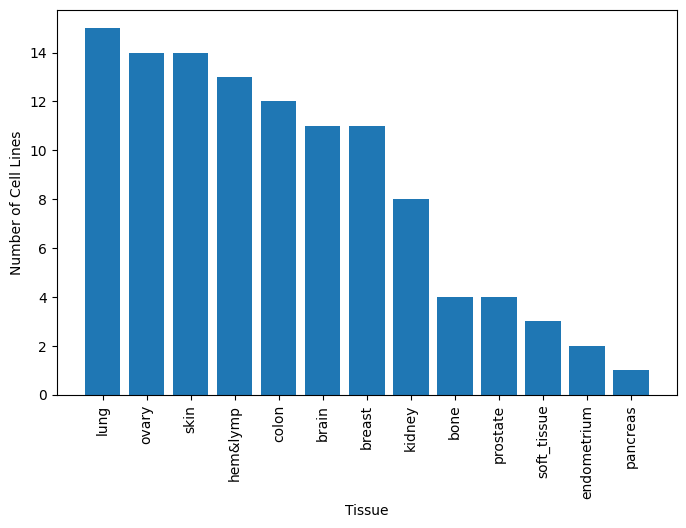

In [33]:
tissue_cell_cnts = cell_line_tissue.groupby('tissue_id').count().sort_values(by='disease_id', ascending=False)['disease_id']
plt.figure(figsize=(8,5))
plt.bar([codes['tissue'].idx2item[tissue_id] for tissue_id in tissue_cell_cnts.index], tissue_cell_cnts)
plt.xticks(rotation=90)
plt.xlabel('Tissue')
plt.ylabel('Number of Cell Lines')

#plt.savefig(data_path+'tissue_num_cell.png', bbox_inches='tight', dpi=200)

##### <a id='toc1_4_2_6_2_'></a>[Aligning Cell Lines with Gene Expression(s)](#toc0_)

Next, using the `gene_identifiers` and `cell_line_meta` files, we can align the cell lines with their respective gene expressions from Broad Institute and SANGAR

Load in the data

In [34]:
gene_identifiers = pd.read_csv(f'{DATA_PATH}/gene/raw/gene_identifiers_latest.csv')
cell_line_meta = pd.read_csv(f'{DATA_PATH}/cell/raw/cell_line_meta.csv')
fpkm_broad = pd.read_csv(f'{DATA_PATH}/gene/raw/fpkm_broad.csv')
fpkm_sangar = pd.read_csv(f'{DATA_PATH}/gene/raw/fpkm_sangar.csv')

Map the gene ids to the cell lines

In [35]:
_codes={}
_codes['gene_id2hgnc_symbol'] = gene_identifiers[['gene_id', 'hgnc_symbol']].set_index('gene_id').to_dict('index')
_codes['SANGAR_ID2cell_name'] = cell_line_meta.loc[cell_line_meta['name'].isin(codes['cell'].idx2item) & ~cell_line_meta['SANGAR_ID'].isna(), ['SANGAR_ID', 'name']].set_index('SANGAR_ID').to_dict('index')

Align the gene expressions from Broad Institute

In [36]:
fpkm_broad = fpkm_broad.loc[fpkm_broad['model_id'].isin(_codes['SANGAR_ID2cell_name'])]#apply(lambda x: _codes['SANGAR_ID2cell_name'].get(x))
fpkm_broad['model_id'] = fpkm_broad['model_id'].apply(lambda x: codes['cell'].item2idx[_codes['SANGAR_ID2cell_name'][x]['name']])
fpkm_broad.rename(columns={col:_codes['gene_id2hgnc_symbol'][col]['hgnc_symbol'] for col in fpkm_broad.columns[1:]}, inplace=True)

fpkm_broad.rename(columns={'model_id':'cell_id'}, inplace=True)
fpkm_broad.set_index('cell_id', inplace=True)


Sanity check

In [37]:
(fpkm_broad.sum()>0).sum()

21732

Align gene expressions from SANGAR

In [38]:
fpkm_sangar = pd.read_csv(f'{DATA_PATH}/gene/raw/fpkm_sangar.csv')

fpkm_sangar = fpkm_sangar.loc[fpkm_sangar['model_id'].isin(_codes['SANGAR_ID2cell_name'])]#apply(lambda x: _codes['SANGAR_ID2cell_name'].get(x))
fpkm_sangar['model_id'] = fpkm_sangar['model_id'].apply(lambda x: codes['cell'].item2idx[_codes['SANGAR_ID2cell_name'][x]['name']])
fpkm_sangar.rename(columns={col:_codes['gene_id2hgnc_symbol'][col]['hgnc_symbol'] for col in fpkm_sangar.columns[1:]}, inplace=True)

fpkm_sangar.rename(columns={'model_id':'cell_id'}, inplace=True)
fpkm_sangar.set_index('cell_id', inplace=True)


Sanity check

In [39]:
(fpkm_sangar.sum()>0).sum()

18421

Finally, integrate gene expressions from Broad Institute and SANGAR into the cell lines

In [40]:
cell_gene_fpkm = pd.concat([fpkm_broad,fpkm_sangar], sort=True) 
cell_gene_fpkm = cell_gene_fpkm.loc[:,(cell_gene_fpkm.std(skipna=True)!=0)] #drop genes with std=0
cell_gene_fpkm.fillna(0, inplace=True)

cell_gene_fpkm_norm = ((cell_gene_fpkm-cell_gene_fpkm.mean())/cell_gene_fpkm.std()) #z-score, gene-wise

unique_genes_cell = cell_gene_fpkm_norm.columns.to_list()

Check the unique genes across all cell lines

In [41]:
len(unique_genes_cell)

22586

##### <a id='toc1_4_2_6_3_'></a>[Gene Integration](#toc0_)

After getting the unique genes for the cell lines, we can map them to indices in our codes 

In [42]:
codes['gene'] = Mapping(set(unique_genes_cell).union(set(unique_genes_drug)))

And again count the number of unique genes we have mapped

In [43]:
len(codes['gene'].idx2item)

24342

Finally, we map the genes back to our drugs data and extract a subset of drug information to serve as our features for training the model

In [44]:
drug['gene_id']=drug['gene'].apply(lambda genes: [codes['gene'].item2idx[gene] for gene in genes])
drug_features = drug[['id', 'smiles', 'fps', 'gene_id']].groupby('id').first()

Save the drug features

In [45]:
drug_features.to_pickle(f'{DATA_PATH}/drug/processed/drug_features.p')

We then merge the cell line's tissue and disease type with the gene

In [46]:
cell_gene = cell_gene_fpkm_norm.apply(lambda row: {codes['gene'].item2idx[gene]:row[gene] for gene in cell_gene_fpkm_norm.columns}, axis=1).reset_index()
cell_gene.rename(columns={0:'gene_id'}, inplace=True)
cell_gene = cell_gene.groupby('cell_id').first()
cell_line = pd.merge(cell_line_tissue, cell_gene, how='left', on='cell_id')
cell_line['gene_id']=cell_line['gene_id'].apply(lambda x: {} if type(x) is float else x)

And save the updated cell lines and our code map for later use

In [47]:
cell_line.to_pickle(f'{DATA_PATH}/cell/processed/cell_features.p')
pickle.dump(codes, open(f'{DATA_PATH}/summary/processed/codes.p', 'wb'))

##### <a id='toc1_4_2_6_4_'></a>[Data Exploration](#toc0_)

For data exploration and visualization purposes, we will add the cell line's tissue information into our summary table

In [48]:
summary_mean['tissue'] = summary_mean['cell_line_name'].apply(lambda x: cell_line_tissue.loc[x, 'tissue_id'])

Plot number of blocks per cell line

Text(0, 0.5, 'number of blocks')

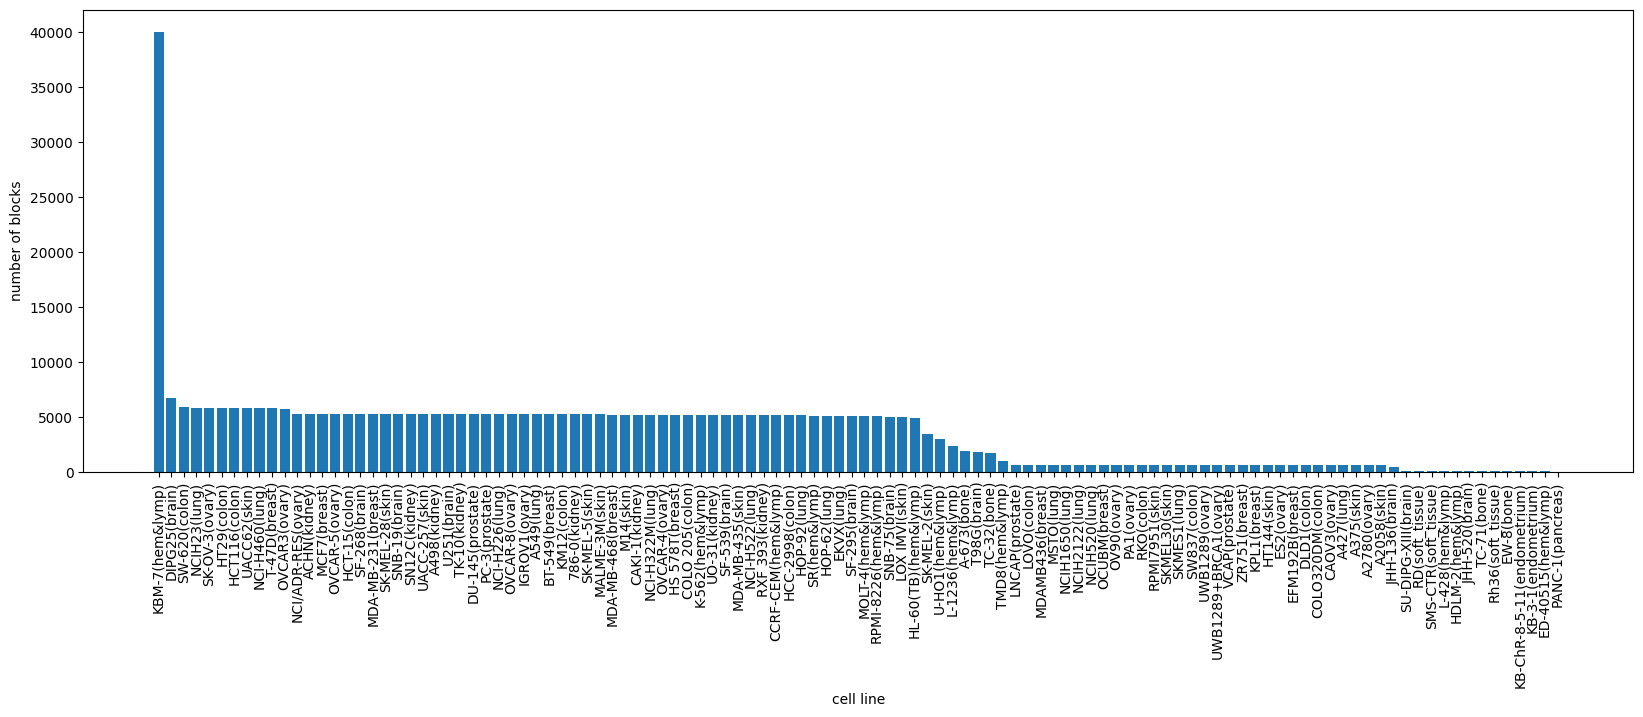

In [49]:
cell_line_exp = summary_mean.groupby('cell_line_name').count()['drug_row'].sort_values(ascending=False)

plt.figure(figsize=(20,6))
plt.bar([codes['cell'].idx2item[cell_id]
         +'('+codes['tissue'].idx2item[cell_line_tissue.loc[cell_id, 'tissue_id']]
         +')' for cell_id in cell_line_exp.index], cell_line_exp)
plt.xticks(rotation=90)
plt.xlabel('cell line')
plt.ylabel('number of blocks')

Plot number of blocks per tissue


Text(0, 0.5, 'number of drug combinations')

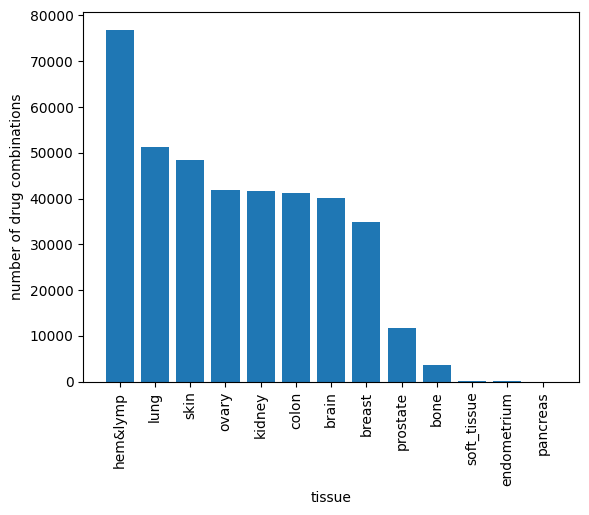

In [50]:
tissue_exp = summary_mean.groupby('tissue').count()['drug_row'].sort_values(ascending=False)

plt.bar([codes['tissue'].idx2item[tissue_id] for tissue_id in tissue_exp.index], tissue_exp)
plt.xticks(rotation=90)
plt.xlabel('tissue')
plt.ylabel('number of drug combinations')
#plt.savefig(data_path+'tissue_num_comb.png', bbox_inches='tight', dpi=200)

Plot number of blocks per study & tissue

In [51]:
study_ids = ['', 'ONEIL','CLOUD','ALMANAC','FORCINA','NCATS_ATL','Mathews','NCATS_DIPG','NCATS_ES(FAKi/AURKi)','NCATS_ES(Nampt+PARP)','Wilson','NCATS_HL','Yohe','NCATS_2D_3D','Phelan','NCATS_MDR_CS','CCLE','CTRPv2','FIMM','gCSI','GDSC1','GRAY','UHNBreast','BEATAML'] #from study.csv
num_blocks = summary_mean.groupby(['study_id', 'tissue'], as_index=False)['drug_row'].count().rename(columns={'drug_row':'num_blocks'})
num_blocks['tissue'] = num_blocks['tissue'].apply(lambda x: codes['tissue'].idx2item[x])
num_blocks['study_id'] = num_blocks['study_id'].apply(lambda x: study_ids[int(x)])

# num_blocks_pivot=num_blocks.pivot("study_id", "tissue", "num_blocks").fillna(0)
num_blocks_pivot = num_blocks.pivot(index="study_id", columns="tissue", values="num_blocks").fillna(0)
num_blocks_pivot = num_blocks_pivot.loc[['ALMANAC', 'CLOUD', 'NCATS_HL', 'FORCINA','Mathews','Wilson','Yohe','NCATS_MDR_CS','Phelan','NCATS_ATL','NCATS_2D_3D',
                      'NCATS_DIPG', 'NCATS_ES(FAKi/AURKi)',
                      'NCATS_ES(Nampt+PARP)','ONEIL'],
                     ['brain','breast','colon','endometrium','hem&lymp','kidney','lung','ovary',
                      'bone','prostate']]

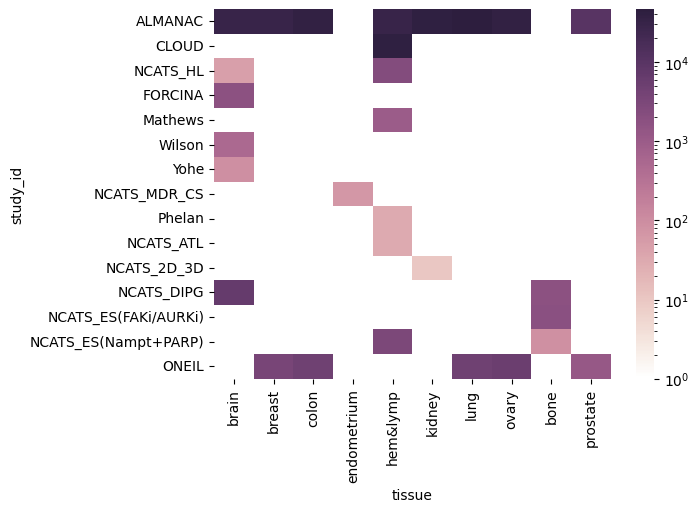

In [52]:
log_norm = LogNorm(vmin=num_blocks_pivot.min().min()+1, vmax=num_blocks_pivot.max().max())
cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(num_blocks_pivot.min().min()+1)), 1+math.ceil(math.log10(num_blocks_pivot.max().max())))]

cmap = sns.cubehelix_palette(light=1, as_cmap=True)

ax = sns.heatmap(num_blocks_pivot.replace(0,1),
           norm=log_norm,
            cbar_kws={'ticks':cbar_ticks},
            cmap=cmap)

#fig=ax.get_figure()
#fig.tight_layout()
#fig.savefig(data_path+'study_heatmap.png', dpi=200)

Counts number of unique drugs for each tissue

In [53]:
tissue_drugs = pd.merge(summary_mean.groupby('tissue')['drug_row'].apply(set).reset_index(name='drug_row'),
         summary_mean.groupby('tissue')['drug_col'].apply(set).reset_index(name='drug_row'),
         on='tissue')
tissue_drugs['drugs']=tissue_drugs.apply(lambda row: row[1].union(row[2]), axis=1)
tissue_drugs.drop(['drug_row_x','drug_row_y'], axis=1, inplace=True)

In [54]:
tissue_drugs['num_drugs']=tissue_drugs['drugs'].apply(lambda x: len(x))
tissue_drugs.sort_values('num_drugs', ascending=False, inplace=True)

Text(0, 0.5, 'number of unique drugs')

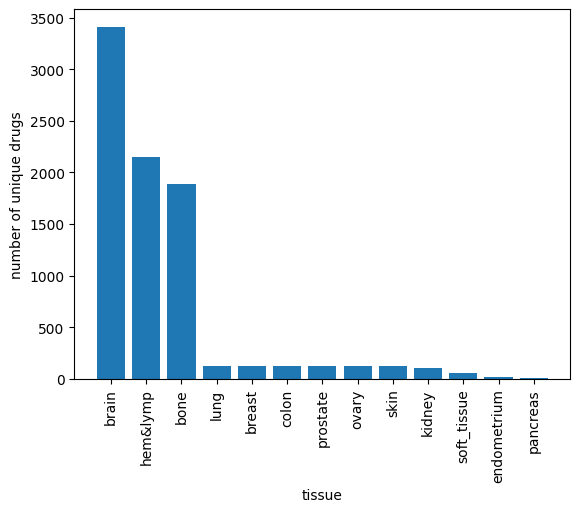

In [55]:
plt.bar([codes['tissue'].idx2item[tissue_id] for tissue_id in tissue_drugs['tissue']], tissue_drugs['num_drugs'])
plt.xticks(rotation=90)
plt.xlabel('tissue')
plt.ylabel('number of unique drugs')
#plt.savefig(data_path+'tissue_num_drugs.png', bbox_inches='tight', dpi=200)

Count number of shared drugs between tissues

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

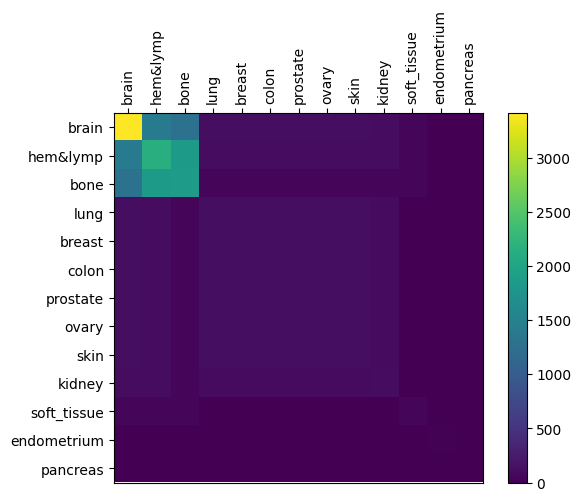

In [56]:
num_intersects=np.zeros((len(tissue_drugs),len(tissue_drugs)))
for i, tissue_id in enumerate(tissue_drugs['tissue']):    
    num_intersects[i,:]=tissue_drugs['drugs'].apply(lambda x: len(x.intersection(tissue_drugs.loc[tissue_id, 'drugs']))).values


fig,ax=plt.subplots()
im=ax.imshow(num_intersects)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
ax.set_xticks(np.arange(len(tissue_drugs)))
ax.set_yticks(np.arange(len(tissue_drugs)))
ax.set_xticklabels([codes['tissue'].idx2item[tissue_id] for tissue_id in tissue_drugs['tissue']])
ax.set_yticklabels([codes['tissue'].idx2item[tissue_id] for tissue_id in tissue_drugs['tissue']])

fig.colorbar(im, ax=ax)

plt.setp(ax.get_xticklabels(), rotation=90)
#fig.tight_layout()
#plt.savefig(data_path+'heatmap.png', bb_inches='tight', dpi=200)

At this point, we have successfully preprocessed all of the data required to train the model. In the next section, we will load this data back in, define the model architecture, and begin training

### <a id='toc1_4_3_'></a>[Model](#toc0_)

#### <a id='toc1_4_3_1_'></a>[Architecture](#toc0_)

The model architecture is designed to integrate multi-modal data inputs and predict two main outputs: monotherapy sensitivity and combination drug synergy. This architecture comprises several components:

##### <a id='toc1_4_3_1_1_'></a>[Drug Encoder](#toc0_)

This component processes the features of each drug, which include drug ID, MACCS fingerprints, canonical SMILES (a text notation for describing the structure of chemical species), and target genes. These features are transformed into embeddings, which are compact vector representations that capture the essence of the input features. SMILES sequences, which vary in length, are handled by a Transformer encoder—a type of model that is highly effective in managing sequence data in natural language processing.

<div align="center">
    <img src="public/assets/drug_encoder_figure.png" width="300">
    <p><b>Figure 1:</b> Drug Encoder Diagram from <a href="https://doi.org/10.1101/2020.02.05.932657">Kim et al. (2020)</a></p>
</div>

##### <a id='toc1_4_3_1_2_'></a>[Cell Line Encoder](#toc0_)

Similar to the drug encoder, this component processes features related to cell lines, such as cell line ID, tissue type, cancer type, and gene expression profiles. These features are also converted into embeddings to facilitate further analysis.

<div align="center">
    <img src="public/assets/cell_line_encoder_figure.png" width="300">
    <p><b>Figure 2:</b> Cell Line Encoder Diagram from <a href="https://doi.org/10.1101/2020.02.05.932657">Kim et al. (2020)</a></p>
</div>

##### <a id='toc1_4_3_1_3_'></a>[Merging Layers](#toc0_)

 The embeddings from the drug encoder and the cell line encoder are combined and fed into a neural network to predict the drug response. This part of the network uses feed-forward layers with ReLU activation functions to process the combined embeddings for final output predictions.

 <div align="center">
    <img src="public/assets/encoding_scheme_figure.png" width="500">
    <p><b>Figure 3:</b> Merging Drug and Cell Lines Encoders Diagram from <a href="https://doi.org/10.1101/2020.02.05.932657">Kim et al. (2020)</a></p>
</div>

#### <a id='toc1_4_3_2_'></a>[Configuration](#toc0_)

Import modules

In [57]:
import os
import torch
import numpy as np
import pandas as pd
import pdb
import time
import pickle
import logging
import matplotlib.pyplot as plt
from utilities import Mapping


import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 

Set parameters

In [58]:
DATA_PATH='synergy_transfer_data'

bsz=128
cuda=True
device=0
torch.cuda.set_device(device)

num_gene_compressed_drug=64
num_gene_compressed_cell=128

#isClassification=True #False for regression task
syn_threshold=30
ri_threshold=50

log_interval=100
epochs=10

Load the summary and codes

In [59]:
df=pickle.load(open(f'{DATA_PATH}/summary/processed/summary_mean.p', 'rb'))
codes=pickle.load(open(f'{DATA_PATH}/summary/processed/codes.p', 'rb'))

In [60]:
df.head()

,drug_row,drug_col,cell_line_name,study_id,ri_row,ri_col,synergy_loewe
0,3528,3467,0,4.0,-21.0794,17.392589,4.436431
1,702,2554,1,6.0,-20.0430,25.595000,-44.555935
2,702,2003,1,6.0,-9.7760,29.111000,-37.189720
3,2554,2554,2,12.0,6.7970,6.964000,1.283298
4,2554,2554,3,12.0,11.5280,7.190000,-3.028745


Load drug external features

In [61]:
drug_features=pickle.load(open(f'{DATA_PATH}/drug/processed/drug_features.p', 'rb'))

Load cell external features

In [62]:
cell_features=pickle.load(open(f'{DATA_PATH}/cell/processed/cell_features.p', 'rb'))

Set parameters based on size of data

In [63]:
num_celllines= len(codes['cell'].idx2item)
num_drugs=len(codes['drugs'].idx2item)

num_genes = len(codes['gene'].idx2item)
num_tissue = len(codes['tissue'].idx2item)
num_disease = len(codes['disease'].idx2item)

num_drug_fp=len(drug_features.loc[0,'fps'])
max_drug_sm_len = drug_features['smiles'].apply(lambda x: len(x)).max()

#### <a id='toc1_4_3_3_'></a>[Gene Compression](#toc0_)

##### <a id='toc1_4_3_3_1_'></a>[Dataset and Dataloader](#toc0_)

In [64]:
class DrugTargetDataset(Dataset):
    def __init__(self, drug_features):
        self.drug_features = drug_features
    def __len__(self):
        return len(self.drug_features)
    def __getitem__(self,idx):
        gene_ids=self.drug_features.loc[idx, 'gene_id']
        genes=np.zeros(num_genes)
        genes[gene_ids]=1
        
        return genes
    
class CellGeneDataset(Dataset):
    def __init__(self, cell_features):
        self.cell_features = cell_features
    def __len__(self):
        return len(self.cell_features)
    def __getitem__(self,idx):
        gene_ids=self.cell_features.loc[idx,'gene_id']
        genes = np.zeros(num_genes)
        for key,value in gene_ids.items():
            genes[key]=value
            
        return genes
            

In [65]:
#Two layers of fully connected layers
class FC2(nn.Module):
    def __init__(self, in_features, out_features, dropout):
        super(FC2, self).__init__()
        
        self.bn = nn.BatchNorm1d(in_features)
        self.fc1 = nn.Linear(in_features, int(in_features/2))
        self.fc2 = nn.Linear(int(in_features/2),out_features)
        self.dropout= nn.Dropout(dropout)
                
    def forward(self, x):
        x = self.bn(x)
        x = self.dropout(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x


##### <a id='toc1_4_3_3_2_'></a>[Compress gene features](#toc0_)

In [66]:
class GeneCompressor(nn.Module):
    def __init__(self, num_in, num_out, dropout=0.1):
        super(GeneCompressor, self).__init__()
        self.dropout=dropout
        self.encoder=nn.Linear(num_in, num_out)
        self.decoder=nn.Linear(num_out,num_in)

    def _encoder(self,x):
        return F.dropout(F.relu(self.encoder(x)), self.dropout, training=self.training)
    
    def _decoder(self,x):
        return F.dropout(self.decoder(x), self.dropout, training=self.training)
    
    def forward(self, x):
        x=self._encoder(x)
        x=self._decoder(x)
        return x

In [67]:
def geneCompressing(data_loader,num_gene_compressed, noise_weight=0.2, epochs=20, log_interval=10 ):
    #model
    geneCompressor=GeneCompressor(num_genes, num_out=num_gene_compressed, dropout=0.1)
    if cuda: 
        geneCompressor=geneCompressor.cuda()
    criterion=nn.MSELoss()
    optimizer=optim.Adam(geneCompressor.parameters())

    for epoch in range(1,epochs+1):
        #train
        geneCompressor.train()
        total_loss=0
        start_time=time.time()
        for iteration, gene in enumerate(data_loader):
            gene=Variable(gene).float()
            noise=noise_weight*torch.randn(gene.shape)

            if cuda:
                gene=gene.cuda()
                noise=noise.cuda()
            optimizer.zero_grad()
            output=geneCompressor(gene+noise)
            loss=criterion(output,gene)
            loss.backward()
            optimizer.step()
            total_loss += loss.data
            if iteration % log_interval == 0 and iteration > 0:
                cur_loss = total_loss.item() / log_interval
                elapsed = time.time() - start_time
                print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | loss {:8.5f}'.format(epoch, iteration, int(len(data_loader)/bsz), elapsed * 1000/log_interval, cur_loss))
                total_loss = 0
                start_time = time.time()
#         #test
#         geneCompressor.eval()
#         total_loss=0
#         start_time=time.time()
#         with torch.no_grad():
#             for iteration, gene in enumerate(test_data_loader):
#                 gene=Variable(gene).float()
#                 if cuda:
#                     gene=gene.cuda(device)
#                 output=geneCompressor(gene)
#                 loss=criterion(output,gene)
#                 total_loss += loss.data
#             print(total_loss.item()/iteration)
    return geneCompressor


In [68]:
#drug's target gene data
drugGeneDataset=DrugTargetDataset(drug_features)
drugGeneDataset_loader = DataLoader(drugGeneDataset, batch_size=64, shuffle=True)
#learn
drugGeneCompressor=geneCompressing(drugGeneDataset_loader, num_gene_compressed_drug)
#save
drugGeneCompressor.eval()
drugGeneCompressed=np.array([drugGeneCompressor.cpu()._encoder(torch.FloatTensor(drugGeneDataset[d])).data.numpy() for d in range(num_drugs)])
torch.save(drugGeneCompressor.state_dict(), f'{DATA_PATH}/models/drugGeneCompressor.p')
pickle.dump(drugGeneCompressed, open(f'{DATA_PATH}/models/drugGeneCompressed.p', 'wb'))

| epoch   1 |    10/    0 batches | ms/batch 31.56 | loss  0.00790
| epoch   1 |    20/    0 batches | ms/batch 14.72 | loss  0.00530
| epoch   1 |    30/    0 batches | ms/batch 15.43 | loss  0.00506
| epoch   1 |    40/    0 batches | ms/batch 15.96 | loss  0.00512
| epoch   1 |    50/    0 batches | ms/batch 15.98 | loss  0.00444
| epoch   1 |    60/    0 batches | ms/batch 15.23 | loss  0.00451
| epoch   2 |    10/    0 batches | ms/batch 16.78 | loss  0.00410
| epoch   2 |    20/    0 batches | ms/batch 14.97 | loss  0.00347
| epoch   2 |    30/    0 batches | ms/batch 14.86 | loss  0.00289
| epoch   2 |    40/    0 batches | ms/batch 16.68 | loss  0.00247
| epoch   2 |    50/    0 batches | ms/batch 15.74 | loss  0.00204
| epoch   2 |    60/    0 batches | ms/batch 16.15 | loss  0.00181
| epoch   3 |    10/    0 batches | ms/batch 18.75 | loss  0.00154
| epoch   3 |    20/    0 batches | ms/batch 15.98 | loss  0.00117
| epoch   3 |    30/    0 batches | ms/batch 16.10 | loss  0.0

In [69]:
drugGeneCompressed=pickle.load(open(f'{DATA_PATH}/models/drugGeneCompressed.p', 'rb'))
drugGeneCompressed=torch.FloatTensor(drugGeneCompressed)

In [70]:

#cell line's gene expression data
cellGeneDataset=CellGeneDataset(cell_features)
cellGeneDataset_loader = DataLoader(cellGeneDataset, batch_size=64, shuffle=True)
#learn
cellGeneCompressor=geneCompressing(cellGeneDataset_loader,num_gene_compressed_cell, noise_weight=0.01, log_interval=1 )
#save
cellGeneCompressor.eval()
cellGeneCompressed=np.array([cellGeneCompressor.cpu()._encoder(torch.FloatTensor(cellGeneDataset[d])).data.numpy() for d in range(num_celllines)])
torch.save(cellGeneCompressor.state_dict(), f'{DATA_PATH}/models/cellGeneCompressor.p')
pickle.dump(cellGeneCompressed, open(f'{DATA_PATH}/models/cellGeneCompressed.p', 'wb'))


| epoch   1 |     1/    0 batches | ms/batch 155.43 | loss  2.29992
| epoch   2 |     1/    0 batches | ms/batch 152.85 | loss  3.31703
| epoch   3 |     1/    0 batches | ms/batch 153.76 | loss  2.99331
| epoch   4 |     1/    0 batches | ms/batch 161.74 | loss  2.58272
| epoch   5 |     1/    0 batches | ms/batch 155.35 | loss  2.24655
| epoch   6 |     1/    0 batches | ms/batch 155.01 | loss  2.06670
| epoch   7 |     1/    0 batches | ms/batch 154.29 | loss  2.00173
| epoch   8 |     1/    0 batches | ms/batch 152.88 | loss  1.86386
| epoch   9 |     1/    0 batches | ms/batch 153.28 | loss  1.79390
| epoch  10 |     1/    0 batches | ms/batch 154.21 | loss  1.67008
| epoch  11 |     1/    0 batches | ms/batch 155.46 | loss  1.64380
| epoch  12 |     1/    0 batches | ms/batch 154.56 | loss  1.58257
| epoch  13 |     1/    0 batches | ms/batch 153.29 | loss  1.62956
| epoch  14 |     1/    0 batches | ms/batch 151.98 | loss  1.54405
| epoch  15 |     1/    0 batches | ms/batch 153

In [71]:
cellGeneCompressed=pickle.load(open(f'{DATA_PATH}/models/cellGeneCompressed.p', 'rb'))
cellGeneCompressed=torch.FloatTensor(cellGeneCompressed)

#### <a id='toc1_4_3_4_'></a>[Synergy prediction](#toc0_)

##### <a id='toc1_4_3_4_1_'></a>[Train/test split in cross or external validation](#toc0_)

In [72]:
def get_cell_of_interest(tissues):
    tissues_of_interests = [codes['tissue'].item2idx[minor_tissue] for minor_tissue in tissues]
    cell_of_interest = cell_features.index[cell_features['tissue_id'].isin(tissues_of_interests)].tolist()
    return cell_of_interest

Train/test for general model

In [73]:
minor_tissues=['bone', 'prostate' ]
cell_of_interest = get_cell_of_interest(minor_tissues)
df_tissue_of_interest = df.loc[df['cell_line_name'].isin(cell_of_interest),:]
df_all = df.drop(df_tissue_of_interest.index)
#specific database
#df_all=df_all.loc[df_all['study_id']==3]
#cross validation
df_train, df_test = train_test_split(df_all, test_size=0.2) #cross validation
#external validation
#df_train=df_all.loc[df_all['study_id']==3] 3: 'ALMANAC'
#df_test=df_all.loc[df_all['study_id']==1] 1: 'ONEIL'

Train/test for bone

In [74]:
_df_bone = df.loc[df['cell_line_name'].isin(get_cell_of_interest(['bone'])),:]
# Cross validation
_df_train_bone, _df_test_bone = train_test_split(_df_bone, test_size=0.2, random_state=1)
# External validation
#_df_train_bone=_df_bone.loc[_df_bone['study_id']!=9]
#_df_test_bone= _df_bone.loc[_df_bone['study_id']==9]

Train/test for prostate

In [75]:
_df_prostate= df.loc[df['cell_line_name'].isin(get_cell_of_interest(['prostate'])),:]
#Cross validation
_df_train_prostate, _df_test_prostate = train_test_split(_df_prostate, test_size=0.2, random_state=1)
# External validation
#_df_train_prostate=_df_prostate.loc[_df_prostate['study_id']!=1]
#_df_test_prostate=_df_prostate.loc[_df_prostate['study_id']==1]

##### <a id='toc1_4_3_4_2_'></a>[Dataset and Dataloader](#toc0_)

In [76]:
class DrugCombDataset(Dataset):
    def __init__(self, df, drug_features, cell_features):
        self.df = df
        self.drug_features = drug_features
        self.cell_features = cell_features
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        d1 = self.df.iloc[idx, 0]
        d2 = self.df.iloc[idx, 1]
        cell = self.df.iloc[idx,2]
        ri_d1 = 1.0 if self.df.iloc[idx,3] >ri_threshold else 0
        ri_d2 = 1.0 if self.df.iloc[idx,4] >ri_threshold else 0
        syn = 1.0 if self.df.iloc[idx, 5] >syn_threshold else 0
        
        
        #external features
        d1_fp = np.array(self.drug_features.loc[d1, 'fps'])
        d1_sm = self.drug_features.loc[d1, 'smiles']
        d1_sm = np.pad(d1_sm, pad_width=(0, max_drug_sm_len-len(d1_sm)), mode='constant', constant_values=0)
        d1_gn=drugGeneCompressed[d1]
        
        d2_fp = np.array(self.drug_features.loc[d2, 'fps'])
        d2_sm = self.drug_features.loc[d2, 'smiles']
        d2_sm = np.pad(d2_sm, pad_width=(0, max_drug_sm_len-len(d2_sm)), mode='constant', constant_values=0)
        d2_gn=drugGeneCompressed[d2]
        
        c_ts = self.cell_features.loc[cell, 'tissue_id']
        c_ds = self.cell_features.loc[cell, 'disease_id']
        c_gn= cellGeneCompressed[cell]
        
        sample = {
            'd1': d1,
            'd1_fp': d1_fp,
            'd1_sm': d1_sm,
            'd1_gn': d1_gn,
            
            'd2': d2,
            'd2_fp': d2_fp,
            'd2_sm': d2_sm,
            'd2_gn': d2_gn,
            
            'cell': cell,
            'c_ts': c_ts,
            'c_ds': c_ds, #missing -1
            'c_gn': c_gn,
            
            'ri_d1': ri_d1,
            'ri_d2': ri_d2,
            'syn': syn
        }
        
        return sample

##### <a id='toc1_4_3_4_3_'></a>[Load dataset](#toc0_)

General model

In [77]:
train = DrugCombDataset(df_train, drug_features, cell_features)
train_loader = DataLoader(train, batch_size=bsz, shuffle=True )
test = DrugCombDataset(df_test, drug_features, cell_features)
test_loader = DataLoader(test, batch_size=bsz, shuffle=True )

Bone

In [78]:
_train_bone = DrugCombDataset(_df_train_bone, drug_features, cell_features)
_train_loader_bone = DataLoader(_train_bone, batch_size=bsz, shuffle=True )
_test_bone = DrugCombDataset(_df_test_bone, drug_features, cell_features)
_test_loader_bone = DataLoader(_test_bone, batch_size=bsz, shuffle=False )

Prostate

In [79]:
_train_prostate = DrugCombDataset(_df_train_prostate, drug_features, cell_features)
_train_loader_prostate = DataLoader(_train_prostate, batch_size=bsz, shuffle=True )
_test_prostate = DrugCombDataset(_df_test_prostate, drug_features, cell_features)
_test_loader_prostate = DataLoader(_test_prostate, batch_size=bsz, shuffle=False )

#### <a id='toc1_4_3_5_'></a>[Prediction model](#toc0_)

In [80]:
class DrugEncoder(nn.Module):
    def __init__(self,
                 num_drugs=num_drugs,
                 num_ID_emb=0,
                 num_drug_fp=num_drug_fp,
                 max_drug_sm_len=max_drug_sm_len,
                 num_gene = num_gene_compressed_drug,
                 num_comp_char=len(codes['mole'].idx2item),
                 fp_embed_sz = 32,
                 gene_embed_sz = int(num_gene_compressed_drug/2),
                 out_size=64,
                 dropout=0.3):
        super(DrugEncoder, self).__init__()
        
        self.dropout= dropout
        #DRUG
        #drug ID
        #self.embed_id = nn.Embedding(num_drugs, num_ID_emb)
        
        #compound ID
        self.embed_comp = nn.Embedding(num_comp_char, num_comp_char, padding_idx=0)#padding's idx=0
        #encoding compound
        self.encoderlayer = nn.TransformerEncoderLayer(d_model=num_comp_char, nhead=4)
        self.encoder = nn.TransformerEncoder(self.encoderlayer, num_layers=1)
        
        #fingerprint
        self.dense_fp = nn.Linear(num_drug_fp,fp_embed_sz)
        #gene
        self.dense_gene = nn.Linear(num_gene,gene_embed_sz)
        
        #depthwise for compound encoding
        self.conv = nn.Conv2d(1, 1, (1, num_comp_char), groups=1)
        
        #combined
        combined_sz = num_ID_emb+fp_embed_sz+max_drug_sm_len+gene_embed_sz
        self.FC2 = FC2(combined_sz, out_size, dropout)

    def forward(self, d_list):
        """
            id: bsz*1
            fp: bsz*num_drug_fp
            sm: bsz*max_drug_sm_len
        """
        id, fp, sm, gn = d_list
        
        sm = self.embed_comp(sm) #bsz*max_drug_sm_len*num_comp_char(embedding size)
        sm = self.encoder(sm)
        sm = self.conv(sm.unsqueeze(1)).squeeze()
        
        fp = F.relu(self.dense_fp(fp))
        gn = F.relu(self.dense_gene(gn))
        
        #combine
        x = torch.cat((fp, sm, gn),1) # bsz*[num_emb_id+num_drug_fp+max+drug_sm]
        x = self.FC2(x)
        
        return x
        

In [81]:
class CellEncoder(nn.Module):
    def __init__(self,
                 num_cells=num_celllines,
                 num_tissue=0,
                 num_disease=num_disease,
                 num_ID_emb=0,
                 gene_embed_sz=int(num_gene_compressed_cell/2),
                 num_gene=num_gene_compressed_cell,
                 out_size=64,
                 dropout=0.3):
        super(CellEncoder, self).__init__()
        
        self.dropout= dropout
        #cell ID
        #self.embed_id = nn.Embedding(num_cells, num_ID_emb)
        #cell tissue
        #self.embed_ts = nn.Embedding(num_tissue, num_tissue)
        #cell disease
        self.embed_ds = nn.Embedding(num_disease, num_disease, padding_idx=3)
        #gene
        self.dense_gene = nn.Linear(num_gene,gene_embed_sz)
        
        #combined
        combined_sz = num_ID_emb+num_tissue+num_disease+gene_embed_sz
        self.FC2 = FC2(combined_sz, out_size, dropout)
    
        
    def forward(self, c_list):
        """
            id: bsz*1
            fp: bsz*num_drug_fp
            sm: bsz*max_drug_sm_len
        """
        id, ts, ds, gn = c_list
        ds = F.relu(self.embed_ds(ds)) #bsz*num_diesaes
        
        gn = F.relu(self.dense_gene(gn)) #bsz*gene_embed_sz
        
        #combine
        x = torch.cat((ds, gn),1) # bsz*combined_sz
        x = self.FC2(x)

        return x
        

In [82]:
class Comb(nn.Module):
    def __init__(self, num_cells=num_celllines, 
                 num_drugs=num_drugs,
                 num_drug_fp=num_drug_fp,
                 max_drug_sm_len=max_drug_sm_len,
                num_comp_char=len(codes['mole'].idx2item),
                 num_ID_emb=0,
                 out_size=64,
                dropout=0.3):
        
        super(Comb, self).__init__()
        
        self.dropout=dropout    
        #drug
        self.drugEncoder = DrugEncoder()
        #cell
        self.cellEncoder = CellEncoder()
        #fc
        self.fc_syn = FC2(out_size*3, 1, dropout)
        self.fc_ri = FC2(out_size*2, 1, dropout)
        
    def forward(self, d1_list, d2_list, c_list):
        d1 = self.drugEncoder(d1_list)
        d2 = self.drugEncoder(d2_list)
        c = self.cellEncoder(c_list)
        
        syn = self.fc_syn(torch.cat((d1, d2, c),1))
        ri1 = self.fc_ri(torch.cat((d1,c),1))
        ri2 = self.fc_ri(torch.cat((d2,c),1))
        
        return syn, ri1, ri2
    

#### <a id='toc1_4_3_6_'></a>[Training](#toc0_)

The model employs a multi-task learning framework, meaning it simultaneously learns to predict both monotherapy sensitivity and drug combination synergy. This approach helps the model leverage commonalities between the two tasks to improve its predictive accuracy. The training loss is a combination of mean squared error (MSE) for the regression tasks (predicting the exact scores of sensitivity and synergy) and binary cross-entropy for classification tasks (predicting whether a drug combination is above a certain synergy threshold).

Transfer learning is a crucial aspect of the training process. The model first learns from data-rich tissues and then transfers its learned parameters to models targeting understudied tissues. This transfer is fine-tuned with data from the understudied tissues to adapt the model to their specific characteristics.

<div align="center">
    <img src="public/assets/transfer_learning_figure.png" width="700">
    <p><b>Figure 4:</b> Transfer Learning Diagram from <a href="https://doi.org/10.1101/2020.02.05.932657">Kim et al. (2020)</a></p>
</div>

##### <a id='toc1_4_3_6_1_'></a>[Hyperparameters](#toc0_)

We defined the hyperparameters above in Cell 58. These hyperparameters are the same as those used by [Kim et al. (2020)](https://doi.org/10.1101/2020.02.05.932657). This includes 10 total epochs for the general model, a batch size of 128, and a dropout of 0.3. For more information on the default hyperparameters, you can find them all in Cell 58 above in the [Configuration](#configuration) section.

##### <a id='toc1_4_3_6_2_'></a>[Computational Requirements](#toc0_)

In terms of the computational feasibility of this paper, you should be able to perform all data preprocessing and training on your local machine, without a need for any additional computing clusters, assuming you have a GPU. In my own testing, I trained the model for 20 epochs with two different GPUs to compare performance on high versus medium-end consumer GPUs. Specifically, I first ran this notebook using an NVIDIA GTX 4090 GPU, which had no issues at all during training. The average minutes per epoch (m/e) using this hardware was ~3 minutes, for a total runtime of ~30 minutes. I also tested this on a NVIDIA GTX 2060 SUPER GPU, which obviously performed worse in comparison, but not prohibitively so. The 2060 SUPER completed training with 5.5 m/e and a total runtime of ~55 minutes. All tests were carried out using the same conda environment and on Ubuntu 22.04.

In [83]:
model = Comb()
if cuda:
    model = model.cuda()
#Regression
#criterion_mse = nn.MSELoss()
#Classification
criterion_bce = nn.BCEWithLogitsLoss()
optimizer = optim.Adagrad(model.parameters())


/home/blake/miniconda3/envs/synergy/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [84]:
#Training
def training(isAux, data_loader):
    model.train()
    total_loss = 0
    start_time = time.time()

    for iteration, sample in enumerate(data_loader):
        d1=Variable(sample['d1'])
        d1_fp = Variable(sample['d1_fp'].float())
        d1_sm = Variable(sample['d1_sm'])
        d1_gn = Variable(sample['d1_gn'].float())
        
        d2=Variable(sample['d2'])
        d2_fp = Variable(sample['d2_fp'].float())
        d2_sm = Variable(sample['d2_sm'])
        d2_gn = Variable(sample['d2_gn'].float())
        
        cell = Variable(sample['cell'])
        c_ts = Variable(sample['c_ts'])
        c_ds = Variable(sample['c_ds'])
        c_gn = Variable(sample['c_gn'].float())
        
        syn_true = Variable(sample['syn'].float())
        ri_d1=Variable(sample['ri_d1'].float())
        ri_d2=Variable(sample['ri_d2'].float())


        if cuda:
            d1=d1.cuda()
            d1_fp=d1_fp.cuda()
            d1_sm=d1_sm.cuda()
            d1_gn=d1_gn.cuda()
            
            d2=d2.cuda()
            d2_fp=d2_fp.cuda()
            d2_sm=d2_sm.cuda()
            d2_gn=d2_gn.cuda()
            
            cell=cell.cuda()
            c_ts=c_ts.cuda()
            c_ds=c_ds.cuda()
            c_gn=c_gn.cuda()
            
            syn_true=syn_true.cuda()
            ri_d1=ri_d1.cuda()
            ri_d2=ri_d2.cuda()

        optimizer.zero_grad()
        
        syn, ri1, ri2 = model((d1, d1_fp, d1_sm, d1_gn), (d2, d2_fp, d2_sm, d2_gn), (cell, c_ts, c_ds, c_gn) )
        
        if not isAux:
            loss = criterion_bce(syn, syn_true.view(-1,1))
        else:
            loss = criterion_bce(ri1, ri_d1.view(-1,1))+criterion_bce(ri2, ri_d2.view(-1,1))
            
        loss.backward()
        optimizer.step()
        total_loss += loss.data

        if iteration % log_interval == 0 and iteration > 0:
            cur_loss = total_loss.item() / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | loss {:8.5f}'.format(epoch, iteration, int(len(train_loader)/bsz), elapsed * 1000/log_interval, cur_loss))

            total_loss = 0
            start_time = time.time()


In [85]:
def evaluate(data_loader):
    model.eval()
    total_loss = 0
    total_loss_sen = 0

    
    #loss
    with torch.no_grad():
        for iteration, sample in enumerate(data_loader):
            d1=Variable(sample['d1'])
            d1_fp = Variable(sample['d1_fp'].float())
            d1_sm = Variable(sample['d1_sm'])
            d1_gn = Variable(sample['d1_gn'].float())

            d2=Variable(sample['d2'])
            d2_fp = Variable(sample['d2_fp'].float())
            d2_sm = Variable(sample['d2_sm'])
            d2_gn = Variable(sample['d2_gn'].float())

            cell = Variable(sample['cell'])
            c_ts = Variable(sample['c_ts'])
            c_ds = Variable(sample['c_ds'])
            c_gn = Variable(sample['c_gn'].float())

            syn_true = Variable(sample['syn'].float())
            ri_d1=Variable(sample['ri_d1'].float())
            ri_d2=Variable(sample['ri_d2'].float())


            if cuda:
                d1=d1.cuda()
                d1_fp=d1_fp.cuda()
                d1_sm=d1_sm.cuda()
                d1_gn=d1_gn.cuda()

                d2=d2.cuda()
                d2_fp=d2_fp.cuda()
                d2_sm=d2_sm.cuda()
                d2_gn=d2_gn.cuda()

                cell=cell.cuda()
                c_ts=c_ts.cuda()
                c_ds=c_ds.cuda()
                c_gn=c_gn.cuda()

                syn_true=syn_true.cuda()
                ri_d1=ri_d1.cuda()
                ri_d2=ri_d2.cuda()


            syn,ri1,ri2 = model((d1, d1_fp, d1_sm, d1_gn), (d2, d2_fp, d2_sm, d2_gn), (cell, c_ts,c_ds,c_gn) )
            loss = criterion_bce(syn, syn_true.view(-1,1))
            total_loss +=loss.data
            loss_sen = (criterion_bce(ri1, ri_d1.view(-1,1))+criterion_bce(ri2, ri_d2.view(-1,1)))/2
            total_loss_sen += loss_sen.data

        print('syn mse', total_loss.item()/(iteration+1))
        print('sen_mse', total_loss_sen.item()/(iteration+1))

In [86]:
best_val_loss = None
try:
    for epoch in range(1, epochs+1):
        epoch_start_time = time.time()
        training(False, train_loader)
        training(True, train_loader)
        evaluate(test_loader)
        print('-'*89)
except KeyboardInterrupt:
    print('-'*89)
    print('Existing from training early')

| epoch   1 |   100/   18 batches | ms/batch 62.58 | loss  0.38068
| epoch   1 |   200/   18 batches | ms/batch 61.15 | loss  0.33605
| epoch   1 |   300/   18 batches | ms/batch 59.03 | loss  0.31480
| epoch   1 |   400/   18 batches | ms/batch 61.55 | loss  0.30493
| epoch   1 |   500/   18 batches | ms/batch 58.84 | loss  0.29916
| epoch   1 |   600/   18 batches | ms/batch 58.40 | loss  0.28708
| epoch   1 |   700/   18 batches | ms/batch 58.45 | loss  0.28399
| epoch   1 |   800/   18 batches | ms/batch 61.39 | loss  0.28293
| epoch   1 |   900/   18 batches | ms/batch 58.60 | loss  0.27937
| epoch   1 |  1000/   18 batches | ms/batch 58.79 | loss  0.28504
| epoch   1 |  1100/   18 batches | ms/batch 58.81 | loss  0.27313
| epoch   1 |  1200/   18 batches | ms/batch 62.14 | loss  0.27800
| epoch   1 |  1300/   18 batches | ms/batch 59.00 | loss  0.27238
| epoch   1 |  1400/   18 batches | ms/batch 59.12 | loss  0.25997
| epoch   1 |  1500/   18 batches | ms/batch 59.29 | loss  0.2

In [87]:
model_name = 'id_feat_gene_4'

In [88]:
#model save
torch.save(model.state_dict(), f'{DATA_PATH}/models/{model_name}.p')

In [89]:
#model load
model.load_state_dict(torch.load(f'{DATA_PATH}/models/{model_name}.p'))
model.eval()

Comb(
  (drugEncoder): DrugEncoder(
    (embed_comp): Embedding(48, 48, padding_idx=0)
    (encoderlayer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=48, out_features=48, bias=True)
      )
      (linear1): Linear(in_features=48, out_features=2048, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=2048, out_features=48, bias=True)
      (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=48, out_features=48, bias=True)
          )
          (linear1): Linear(in_features=48, 

#### <a id='toc1_4_3_7_'></a>[Evaluation](#toc0_)

##### <a id='toc1_4_3_7_1_'></a>[Evaluation Metrics](#toc0_)

The model's performance is evaluated using several metrics:

**Area Under the Receiver Operating Characteristic Curve (AUC-ROC)**

This metric evaluates the binary classification performance of the model at various threshold settings. AUC-ROC is a plot of true positive rate against false positive rate at different classification thresholds, and the AUC provides a single scalar value to indicate performance.

**Normalized Discounted Cumulative Gain (NDCG)**

Used in ranking problems, NDCG measures the performance of ranking predictions based on their relevance. It gives more importance to higher-ranked items, thus accommodating the notion that hits at the top of the ranking are more valuable than hits at lower ranks.

In [90]:
def dcg_score(y_score, y_true, k):
    """
        https://www.kaggle.com/davidgasquez/ndcg-scorer
        y_true: np.array, size= [n_samples]
        y_score: np.array, size=[n_samples]
        k: int, rank
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    
    #gain = 2 ** y_true -1
    gain = y_true 
    
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain/discounts)

def evaluate_accuracy(data_loader):
    model.eval()
    
    syn_all=[]
    syn_true_all=[]
    ri1_all=[]
    ri1_true_all=[]
    ri2_all=[]
    ri2_true_all=[]
    
    #loss
    with torch.no_grad():
        for iteration, sample in enumerate(data_loader):
            d1=Variable(sample['d1'])
            d1_fp = Variable(sample['d1_fp'].float())
            d1_sm = Variable(sample['d1_sm'])
            d1_gn = Variable(sample['d1_gn'].float())

            d2=Variable(sample['d2'])
            d2_fp = Variable(sample['d2_fp'].float())
            d2_sm = Variable(sample['d2_sm'])
            d2_gn = Variable(sample['d2_gn'].float())

            cell = Variable(sample['cell'])
            c_ts = Variable(sample['c_ts'])
            c_ds = Variable(sample['c_ds'])
            c_gn = Variable(sample['c_gn'].float())

            syn_true = Variable(sample['syn'].float())
            ri_d1=Variable(sample['ri_d1'])
            ri_d2=Variable(sample['ri_d2'])


            if cuda:
                d1=d1.cuda()
                d1_fp=d1_fp.cuda()
                d1_sm=d1_sm.cuda()
                d1_gn=d1_gn.cuda()

                d2=d2.cuda()
                d2_fp=d2_fp.cuda()
                d2_sm=d2_sm.cuda()
                d2_gn=d2_gn.cuda()

                cell=cell.cuda()
                c_ts=c_ts.cuda()
                c_ds=c_ds.cuda()
                c_gn=c_gn.cuda()


            syn,ri1,ri2 = model((d1, d1_fp, d1_sm, d1_gn), (d2, d2_fp, d2_sm, d2_gn), (cell, c_ts,c_ds,c_gn) )
            
            syn_all.append(syn.data.cpu().numpy())
            syn_true_all.append(syn_true.numpy())
            
            ri1_all.append(ri1.data.cpu().numpy())
            ri1_true_all.append(ri_d1.numpy())
            
            ri2_all.append(ri2.data.cpu().numpy())
            ri2_true_all.append(ri_d2.numpy())
            
    return syn_all, syn_true_all, ri1_all, ri1_true_all, ri2_all, ri2_true_all


Evaluate synergy prediction

In [91]:
syn_all, syn_true_all, ri1_all, ri1_true_all, ri2_all, ri2_true_all= evaluate_accuracy(test_loader)

syn_all= [s.item() for syn in syn_all for s in syn]
syn_true_all = [s for syn in syn_true_all for s in syn]

In [92]:
#NDCG
dcg_score(syn_all,syn_true_all, k=20)/dcg_score(syn_true_all,syn_true_all, k=20)

1.0

In [93]:
#AUPRC
metrics.average_precision_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))

0.8592733054759554

In [94]:
#AUROC
metrics.roc_auc_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))

0.9637493233172485

Evaluate sensitivity prediction

In [95]:
ri1_all= [r.item() for ri in ri1_all for r in ri]
ri1_true_all = [r for ri in ri1_true_all for r in ri]

ri2_all= [r.item() for ri in ri2_all for r in ri]
ri2_true_all = [r for ri in ri2_true_all for r in ri]

ri_all=ri1_all+ri2_all
ri_true_all=ri1_true_all+ri2_true_all

In [96]:
#NDCG
dcg_score(ri_all,ri_true_all, k=20)/dcg_score(ri_true_all,ri_true_all, k=20)

0.1481379966891306

In [97]:
#AUC
metrics.roc_auc_score(ri_true_all,  1/(1 + np.exp(-np.array(ri_all))))

0.8505135065203695

#### <a id='toc1_4_3_8_'></a>[Train Specific Model](#toc0_)

If you want to boost a bit more with general model's test set

In [98]:
#Use major's test set
training(False, test_loader)
training(True, test_loader)

| epoch  10 |   100/   18 batches | ms/batch 64.32 | loss  0.22585
| epoch  10 |   200/   18 batches | ms/batch 63.49 | loss  0.21658
| epoch  10 |   300/   18 batches | ms/batch 63.85 | loss  0.21068
| epoch  10 |   400/   18 batches | ms/batch 64.02 | loss  0.21123
| epoch  10 |   500/   18 batches | ms/batch 64.44 | loss  0.20478
| epoch  10 |   100/   18 batches | ms/batch 65.53 | loss  0.17140
| epoch  10 |   200/   18 batches | ms/batch 65.00 | loss  0.16609
| epoch  10 |   300/   18 batches | ms/batch 65.09 | loss  0.16322
| epoch  10 |   400/   18 batches | ms/batch 65.36 | loss  0.16001
| epoch  10 |   500/   18 batches | ms/batch 65.37 | loss  0.15451


##### <a id='toc1_4_3_8_1_'></a>[Freeze layers](#toc0_)

Examine the layer's ID that we'd like to fix or free

In [99]:
for i, param in enumerate(model.parameters()):
    print(i, param.size(), param.requires_grad)

0 torch.Size([48, 48]) True
1 torch.Size([144, 48]) True
2 torch.Size([144]) True
3 torch.Size([48, 48]) True
4 torch.Size([48]) True
5 torch.Size([2048, 48]) True
6 torch.Size([2048]) True
7 torch.Size([48, 2048]) True
8 torch.Size([48]) True
9 torch.Size([48]) True
10 torch.Size([48]) True
11 torch.Size([48]) True
12 torch.Size([48]) True
13 torch.Size([144, 48]) True
14 torch.Size([144]) True
15 torch.Size([48, 48]) True
16 torch.Size([48]) True
17 torch.Size([2048, 48]) True
18 torch.Size([2048]) True
19 torch.Size([48, 2048]) True
20 torch.Size([48]) True
21 torch.Size([48]) True
22 torch.Size([48]) True
23 torch.Size([48]) True
24 torch.Size([48]) True
25 torch.Size([32, 167]) True
26 torch.Size([32]) True
27 torch.Size([32, 64]) True
28 torch.Size([32]) True
29 torch.Size([1, 1, 1, 48]) True
30 torch.Size([1]) True
31 torch.Size([352]) True
32 torch.Size([352]) True
33 torch.Size([176, 352]) True
34 torch.Size([176]) True
35 torch.Size([64, 176]) True
36 torch.Size([64]) True
37

In [100]:
release_after = 46

In [101]:
for i, param in enumerate(model.parameters()):
    if i>=release_after:
        param.requires_grad=True
    else:
        param.requires_grad=False

Prostate or bone

In [102]:
# _train_loader_minor=_train_loader_prostate
# _test_loader_minor=_test_loader_prostate
# _test_minor=_test_prostate
_train_loader_minor=_train_loader_bone
_test_loader_minor=_test_loader_bone
_test_minor=_test_bone

In [103]:
#Use minor's train set
try:
    for epoch in range(1, epochs+1):
        epoch_start_time = time.time()
        training(False, _train_loader_minor)
        training(True, _train_loader_minor)
        evaluate(_test_loader_minor)
        print('-'*89)
except KeyboardInterrupt:
    print('-'*89)
    print('Existing from training early')

syn mse 0.4604630470275879
sen_mse 0.07659931977589925
-----------------------------------------------------------------------------------------
syn mse 0.43307705720265705
sen_mse 0.07582458853721619
-----------------------------------------------------------------------------------------
syn mse 0.42016200224558514
sen_mse 0.07519650459289551
-----------------------------------------------------------------------------------------
syn mse 0.40270670255025226
sen_mse 0.07492810487747192
-----------------------------------------------------------------------------------------
syn mse 0.39851752916971844
sen_mse 0.07496614257494609
-----------------------------------------------------------------------------------------
syn mse 0.38854416211446124
sen_mse 0.07470616698265076
-----------------------------------------------------------------------------------------
syn mse 0.38684693972269696
sen_mse 0.07444736361503601
---------------------------------------------------------------------

#### <a id='toc1_4_3_9_'></a>[Evaluate Specific Model](#toc0_)

Evaluate synergy prediction

In [104]:
syn_all, syn_true_all, ri1_all, ri1_true_all, ri2_all, ri2_true_all= evaluate_accuracy(_test_loader_minor)

syn_all= [s.item() for syn in syn_all for s in syn]
syn_true_all = [s for syn in syn_true_all for s in syn]

In [105]:
#NDCG
dcg_score(syn_all,syn_true_all, k=20)/dcg_score(syn_true_all,syn_true_all, k=20)

0.5443161681145564

In [106]:
#AUROC
metrics.roc_auc_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))

0.715405562813833

In [107]:
#AUPRC
metrics.average_precision_score(syn_true_all,  1/(1 + np.exp(-np.array(syn_all))))

0.3162988637931727

Evaluate sensitivity prediction

In [108]:
ri1_all= [r.item() for ri in ri1_all for r in ri]
ri1_true_all = [r for ri in ri1_true_all for r in ri]

ri2_all= [r.item() for ri in ri2_all for r in ri]
ri2_true_all = [r for ri in ri2_true_all for r in ri]

ri_all=ri1_all+ri2_all
ri_true_all=ri1_true_all+ri2_true_all

In [109]:
#NDCG
dcg_score(ri_all,ri_true_all, k=20)/dcg_score(ri_true_all,ri_true_all, k=20)

0.0

In [110]:
#AUC
metrics.roc_auc_score(ri_true_all,  1/(1 + np.exp(-np.array(ri_all))))

0.7249652294853963

##### <a id='toc1_4_3_9_1_'></a>[Select the top ranked drug combinations](#toc0_)

In [111]:
syn_all_prob=1/(1 + np.exp(-np.array(syn_all)))
order = np.argsort(syn_all_prob)[::-1]
syn_true_all_order = np.take(syn_true_all, order[:20])

In [112]:
for k in range(20):
    comb=_test_minor[order[k]]
    print(codes['drugs'].idx2item[comb['d1']], ',', 
          codes['drugs'].idx2item[comb['d2']], ',', 
          codes['cell'].idx2item[comb['cell']],  ',', 
          codes['tissue'].idx2item[comb['c_ts']],  ',',
          codes['disease'].idx2item[comb['c_ds']], ',', 
          comb['ri_d1'], ',',
          comb['ri_d2'], ',',
          syn_true_all_order[k])


AK-77283 , CHEMBL2144205 , TC-32 , bone , c3716 , 0 , 0 , 0.0
DASATINIB , BEZ-235 , TC-32 , bone , c3716 , 0 , 0 , 1.0
117048-62-1 , BEZ-235 , TC-32 , bone , c3716 , 0 , 0 , 0.0
CARFILZOMIB (PR-171) , CHEMBL2144205 , TC-32 , bone , c3716 , 0 , 0 , 0.0
Sepantronium , 658084-64-1 , TC-32 , bone , c3716 , 0 , 0 , 1.0
AK-77283 , 658084-64-1 , TC-32 , bone , c3716 , 0 , 0 , 1.0
117048-62-1 , 658084-64-1 , TC-32 , bone , c3716 , 0 , 0 , 1.0
FOSTAMATINIB (R788) , 658084-64-1 , TC-32 , bone , c3716 , 0 , 0 , 1.0
BARDOXOLONE METHYL , 658084-64-1 , TC-32 , bone , c3716 , 0 , 0 , 1.0
PALBOCICLIB , 658084-64-1 , TC-32 , bone , c3716 , 0 , 0 , 1.0
AK-77283 , CARFILZOMIB (PR-171) , TC-71 , bone , c4817 , 0 , 0 , 0.0
AK-77283 , CHEMBL3322515 , TC-32 , bone , c3716 , 0 , 0 , 0.0
MEBENDAZOLE , PD325901 , TC-32 , bone , c3716 , 0 , 0 , 1.0
117048-62-1 , CHEMBL3322515 , TC-32 , bone , c3716 , 0 , 0 , 0.0
ABT-263 (NAVITOCLAX) , 658084-64-1 , TC-32 , bone , c3716 , 0 , 0 , 1.0
TRAMETINIB (GSK1120212) , CHE

## <a id='toc1_5_'></a>[Results](#toc0_)

This section contains

### <a id='toc1_5_1_'></a>[Drug response prediction accuracy for data-rich tissues](#toc0_)

The first experiment involved training the model on a varying number of input features for both cells and drugs. I was unable to refactor the provided code sufficiently to perform the experiments without certain input features, so the results shown in the table are only for the combination of ID, SMILES, and Target Genes. Results shown in Table 1 below:

<div align="center">
<table>
  <tr>
    <th rowspan='2'>Input Features</th>
    <th colspan='2'>Monotherapy Sensitivity</th>
    <th colspan='2'>Combination Synergy</th>
  </tr>
  <tr>
    <td>NDCG</td>
    <td>AUC</td>
    <td>NDCG</td>
    <td>AUC</td>
  </tr>
  <tr>
    <td>ID+F+G</td>
    <td>0.3388</td>
    <td>0.8651</td>
    <td>1.0000</td>
    <td>0.9627</td>
  </tr>
</table>
<p><b>Table 1:</b> Drug response preduction accuracy for data-rich tissues</p>
</div>

Compared to the resuls of the original paper, my own results are a bit mixed. On one hand, the accuracy of the model predictions of combination synergy is actually slightly higher than those reported by [Kim et al. (2020)](https://doi.org/10.1101/2020.02.05.932657) by a margin of approximately 0.08 points. Similarly, the NDCG is comparatively higher at 1.00, whereas the original authors reported an NDCG for combination synergy at 0.8377. These seemingly positive results become more perplexing when we consider the monotherapy sensitivity scores, which are much lower for NDCG and AUC by .0847 and 0.6612 points, respectively. Given that I followed the same approach and used their own architecture for the models themselves, these results are striking. Namely the sensitivity score of 0.3388 for NDCG. The only plausible explanation for the discrepancy leads back to the issue with data. Without any guarantee that the restructuring of the new data to align with the dimensionality of the original data was without errors, it's possible that some key data present in the original models was absent in my own analysis. Perhaps even more confusing is the fact that in spite of these likely unintended data exclusions, the model performed even better at predicting the combination synergy. I can only assume that different data and/or preprocessing step(s) were excluded that might offer some insight into the discrepancies between these scores. 

### <a id='toc1_5_2_'></a>[Drug response prediction accuracy for bone and prostate cancer](#toc0_)

The second experiment shifts the focus of analysis to understudied tissues, namely bone and prostate. To perform this experiment, [Kim et al. (2020)](https://doi.org/10.1101/2020.02.05.932657) transferred the model parameters from data-rich tissues to data-poor tissues, hypothesizing that the model would exhibit improved performance at predicting the synergy and sensitivity for the data-poor tissues given the pretraining. To reproduce this experiment, I followed the same methodology using only the ID+F+G feature model retrained on bone and prostate, respectively. The results can be seen below in Table 2.

<div align="center">
<table>
  <tr>
    <th rowspan='2'>Tissue</th>
    <th rowspan='2'>Input Features</th>
    <th colspan='2'>Monotherapy Sensitivity</th>
    <th colspan='2'>Combination Synergy</th>
  </tr>
  <tr>
    <td>NDCG</td>
    <td>AUC</td>
    <td>NDCG</td>
    <td>AUC</td>
  </tr>
  <tr>
    <td>Bone</td>
    <td>ID+F+G</td>
    <td>0.0000</td>
    <td>0.7074</td>
    <td>0.3760</td>
    <td>0.6655</td>
  </tr>
  <tr>
    <td>Prostate</td>
    <td>ID+F+G</td>
    <td>0.0897</td>
    <td>0.8143</td>
    <td>0.9644</td>
    <td>0.9690</td>
  </tr>
</table>
<p><b>Table 2:</b> Drug response preduction accuracy for bone and prostate cancer</p>
</div>

The results of this experiment were more striking in terms of their deviance from those in the original paper. Namely, the fact that bone received an NDCG score of 0 for monotherapy sensitivity compared with the perfect 1.000 presented in the original paper speaks to the issues in the training data. This is all but confirmed by the fact that scores for combination synergy did not deviate to the same degree. For bone in particular, the NDCG score for combination synergy was 0.3760 and 0.3599 for the reproduction and original paper, respectively. Given I used the same methodology for training the models and computing all of the metrics, the only plausible explanation for the discrepancies ties back to the availability of data for training. Interestingly, prostate did not deviate as significantly from the results in the original paper compared with bone. Granted, the NDCG for monotherapy sensitivity was still much lower at 0.0897 compared to 0.9596, but the AUC for both monotherapy sensitivity and combination synergy outperformed the original results reported in the paper.

### <a id='toc1_5_3_'></a>[Ranking Predicted Synergenistic Drug Combinations](#toc0_)

The final experiment conducted in the original paper was a case study in which the authors listed the top 20 predicted drug combinations based on the estimated probability that those combinations were synergistic. Unfortunately, in all the prints of the paper I researched I was unable to find the table in which they referenced their results for this experiment, but they do make a note on page 8 regarding the percentage of the predictions that were actually synergistic as an accuracy metric for both bone and prostate. To reproduce these experiments, I followed the same methodology for prostate and bone, selecting the top 20 predicted drug combinations and offer the results in Tables 3 and 4, respectively.

#### <a id='toc1_5_3_1_'></a>[Prostate Top Predictions](#toc0_)

<div align="center">
<table>
  <thead>
    <tr>
      <th>#</th>
      <th>Drug 1</th>
      <th>Drug 2</th>
      <th>Cell</th>
      <th>Tissue</th>
      <th>Disease</th>
      <th>ri_d1</th>
      <th>ri_d2</th>
      <th>syn_true_all_order</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>0</td>
      <td>AXITINIB</td>
      <td>CABAZITAXEL</td>
      <td>DU-145</td>
      <td>prostate</td>
      <td>c4863</td>
      <td>0</td>
      <td>0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <td>1</td>
      <td>ACTINOMYCIN D</td>
      <td>IXABEPILONE</td>
      <td>PC-3</td>
      <td>prostate</td>
      <td>c4863</td>
      <td>0</td>
      <td>0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <td>2</td>
      <td>RUXOLITINIB</td>
      <td>CABAZITAXEL</td>
      <td>DU-145</td>
      <td>prostate</td>
      <td>c4863</td>
      <td>0</td>
      <td>0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <td>3</td>
      <td>FLUDARABINE BASE</td>
      <td>IXABEPILONE</td>
      <td>DU-145</td>
      <td>prostate</td>
      <td>c4863</td>
      <td>0</td>
      <td>0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <td>4</td>
      <td>VINBLASTINE SULFATE</td>
      <td>IXABEPILONE</td>
      <td>PC-3</td>
      <td>prostate</td>
      <td>c4863</td>
      <td>0</td>
      <td>0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <td>5</td>
      <td>AMIFOSTINE</td>
      <td>IXABEPILONE</td>
      <td>PC-3</td>
      <td>prostate</td>
      <td>c4863</td>
      <td>0</td>
      <td>0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <td>6</td>
      <td>IMATINIB</td>
      <td>IXABEPILONE</td>
      <td>PC-3</td>
      <td>prostate</td>
      <td>c4863</td>
      <td>0</td>
      <td>0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <td>7</td>
      <td>IMATINIB</td>
      <td>IXABEPILONE</td>
      <td>DU-145</td>
      <td>prostate</td>
      <td>c4863</td>
      <td>0</td>
      <td>0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <td>8</td>
      <td>TOPOTECAN HYDROCHLORIDE</td>
      <td>IXABEPILONE</td>
      <td>DU-145</td>
      <td>prostate</td>
      <td>c4863</td>
      <td>0</td>
      <td>0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <td>9</td>
      <td>HYDROXYUREA</td>
      <td>IXABEPILONE</td>
      <td>PC-3</td>
      <td>prostate</td>
      <td>c4863</td>
      <td>0</td>
      <td>0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <td>10</td>
      <td>TEMOZOLOMIDE</td>
      <td>IXABEPILONE</td>
      <td>PC-3</td>
      <td>prostate</td>
      <td>c4863</td>
      <td>0</td>
      <td>0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <td>11</td>
      <td>CO-V</td>
      <td>IXABEPILONE</td>
      <td>DU-145</td>
      <td>prostate</td>
      <td>c4863</td>
      <td>0</td>
      <td>0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <td>12</td>
      <td>CHEMBL17639</td>
      <td>IXABEPILONE</td>
      <td>DU-145</td>
      <td>prostate</td>
      <td>c4863</td>
      <td>0</td>
      <td>0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <td>13</td>
      <td>PLICAMYCIN</td>
      <td>IXABEPILONE</td>
      <td>DU-145</td>
      <td>prostate</td>
      <td>c4863</td>
      <td>0</td>
      <td>0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <td>14</td>
      <td>ARSENIC TRIOXIDE</td>
      <td>NSC256439</td>
      <td>DU-145</td>
      <td>prostate</td>
      <td>c4863</td>
      <td>0</td>
      <td>0</td>
      <td>0.0</td>
    </tr>
    <tr>
      <td>15</td>
      <td>PRALATREXATE</td>
      <td>IXABEPILONE</td>
      <td>DU-145</td>
      <td>prostate</td>
      <td>c4863</td>
      <td>0</td>
      <td>0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <td>16</td>
      <td>LETROZOLE</td>
      <td>IXABEPILONE</td>
      <td>DU-145</td>
      <td>prostate</td>
      <td>c4863</td>
      <td>0</td>
      <td>0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <td>17</td>
      <td>RUXOLITINIB</td>
      <td>ADM HYDROCHLORIDE</td>
      <td>DU-145</td>
      <td>prostate</td>
      <td>c4863</td>
      <td>0</td>
      <td>0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <td>18</td>
      <td>ACTINOMYCIN D</td>
      <td>ARSENIC TRIOXIDE</td>
      <td>DU-145</td>
      <td>prostate</td>
      <td>c4863</td>
      <td>0</td>
      <td>0</td>
      <td>1.0</td>
    </tr>
    <tr>
      <td>19</td>
      <td>PAZOPANIB HYDROCHLORIDE</td>
      <td>CABAZITAXEL</td>
      <td>PC-3</td>
      <td>prostate</td>
      <td>c4863</td>
      <td>0</td>
      <td>0</td>
      <td>1.0</td>
    </tr>
  </tbody>
</table>
<p><b>Table 3:</b> Top 20 synergy predictions for prostate</p>
</div>


In Table 3 we can see the top 20 predicted synergistic drug combinations for the prostate tissue. According to [Kim et al. (2020)](https://doi.org/10.1101/2020.02.05.932657), they identified that 10 out of the 20 top predicted drug combinations were actually synergistic (50% hit). Indicating that their model had effectively ranked synergistic drug combinations. In my own results, using the indicator column `syn_true_all_order` as a guide, we can see that the ID+F+G prostate model identified truly synergistic drug combinations for 19/20 drugs (95% hit), outperforming the results reported in the original paper.

#### <a id='toc1_5_3_2_'></a>[Bone Top Predictions](#toc0_)

<div align="center">
<table border="1">
    <tr>
        <th>#</th>
        <th>Drug 1</th>
        <th>Drug 2</th>
        <th>Cell</th>
        <th>Tissue</th>
        <th>Disease</th>
        <th>ri_d1</th>
        <th>ri_d2</th>
        <th>syn_true_all_order</th>
    </tr>
    <tr>
        <td>0</td>
        <td>ISODONOL</td>
        <td>PD325901</td>
        <td>TC-32</td>
        <td>bone</td>
        <td>c3716</td>
        <td>0</td>
        <td>0</td>
        <td>1.0</td>
    </tr>
    <tr>
        <td>1</td>
        <td>AK-77283</td>
        <td>OLAPARIB</td>
        <td>TC-71</td>
        <td>bone</td>
        <td>c4817</td>
        <td>0</td>
        <td>0</td>
        <td>0.0</td>
    </tr>
    <tr>
        <td>2</td>
        <td>DASATINIB</td>
        <td>BEZ-235</td>
        <td>TC-32</td>
        <td>bone</td>
        <td>c3716</td>
        <td>0</td>
        <td>0</td>
        <td>1.0</td>
    </tr>
    <tr>
        <td>3</td>
        <td>TRAMETINIB (GSK1120212)</td>
        <td>CUDC-101</td>
        <td>TC-32</td>
        <td>bone</td>
        <td>c3716</td>
        <td>0</td>
        <td>0</td>
        <td>0.0</td>
    </tr>
    <tr>
        <td>4</td>
        <td>CUDC-101</td>
        <td>PD325901</td>
        <td>TC-32</td>
        <td>bone</td>
        <td>c3716</td>
        <td>0</td>
        <td>0</td>
        <td>1.0</td>
    </tr>
    <tr>
        <td>5</td>
        <td>ZINC34894448</td>
        <td>thapsigargin</td>
        <td>TC-32</td>
        <td>bone</td>
        <td>c3716</td>
        <td>0</td>
        <td>0</td>
        <td>0.0</td>
    </tr>
    <tr>
        <td>6</td>
        <td>ZINC34894448</td>
        <td>BARDOXOLONE METHYL</td>
        <td>TC-32</td>
        <td>bone</td>
        <td>c3716</td>
        <td>0</td>
        <td>0</td>
        <td>0.0</td>
    </tr>
    <tr>
        <td>7</td>
        <td>117048-62-1</td>
        <td>CARFILZOMIB (PR-171)</td>
        <td>TC-32</td>
        <td>bone</td>
        <td>c3716</td>
        <td>0</td>
        <td>0</td>
        <td>0.0</td>
    </tr>
    <tr>
        <td>8</td>
        <td>117048-62-1</td>
        <td>Luminespib</td>
        <td>TC-32</td>
        <td>bone</td>
        <td>c3716</td>
        <td>0</td>
        <td>0</td>
        <td>0.0</td>
    </tr>
    <tr>
        <td>9</td>
        <td>ISODONOL</td>
        <td>CUDC-101</td>
        <td>TC-32</td>
        <td>bone</td>
        <td>c3716</td>
        <td>0</td>
        <td>0</td>
        <td>0.0</td>
    </tr>
    <tr>
        <td>10</td>
        <td>AK-77283</td>
        <td>CARFILZOMIB (PR-171)</td>
        <td>TC-71</td>
        <td>bone</td>
        <td>c4817</td>
        <td>0</td>
        <td>0</td>
        <td>0.0</td>
    </tr>
    <tr>
        <td>11</td>
        <td>Fingolimod</td>
        <td>proscillaridin</td>
        <td>TC-32</td>
        <td>bone</td>
        <td>c3716</td>
        <td>0</td>
        <td>0</td>
        <td>1.0</td>
    </tr>
    <tr>
        <td>12</td>
        <td>CHEMBL2140543</td>
        <td>PD325901</td>
        <td>TC-32</td>
        <td>bone</td>
        <td>c3716</td>
        <td>0</td>
        <td>0</td>
        <td>1.0</td>
    </tr>
    <tr>
        <td>13</td>
        <td>BEZ-235</td>
        <td>thapsigargin</td>
        <td>TC-32</td>
        <td>bone</td>
        <td>c3716</td>
        <td>0</td>
        <td>0</td>
        <td>0.0</td>
    </tr>
    <tr>
        <td>14</td>
        <td>CHEMBL2140543</td>
        <td>BARDOXOLONE METHYL</td>
        <td>TC-32</td>
        <td>bone</td>
        <td>c3716</td>
        <td>0</td>
        <td>0</td>
        <td>0.0</td>
    </tr>
    <tr>
        <td>15</td>
        <td>CARFILZOMIB (PR-171)</td>
        <td>PANOBINOSTAT</td>
        <td>TC-32</td>
        <td>bone</td>
        <td>c3716</td>
        <td>0</td>
        <td>0</td>
        <td>0.0</td>
    </tr>
    <tr>
        <td>16</td>
        <td>117048-62-1</td>
        <td>CUDC-101</td>
        <td>TC-32</td>
        <td>bone</td>
        <td>c3716</td>
        <td>0</td>
        <td>0</td>
        <td>0.0</td>
    </tr>
    <tr>
        <td>17</td>
        <td>DORSOMORPHIN</td>
        <td>thapsigargin</td>
        <td>TC-32</td>
        <td>bone</td>
        <td>c3716</td>
        <td>0</td>
        <td>0</td>
        <td>0.0</td>
    </tr>
    <tr>
        <td>18</td>
        <td>BEZ-235</td>
        <td>CUDC-101</td>
        <td>TC-32</td>
        <td>bone</td>
        <td>c3716</td>
        <td>0</td>
        <td>0</td>
        <td>0.0</td>
    </tr>
    <tr>
        <td>19</td>
        <td>117048-62-1</td>
        <td>TRAMETINIB (GSK1120212)</td>
        <td>TC-32</td>
        <td>bone</td>
        <td>c3716</td>
        <td>0</td>
        <td>0</td>
        <td>1.0</td>
    </tr>
</table>
<p><b>Table 4: </b>Top 20 synergy predictions for bone</p>
</div>

In the original paper, [Kim et al. (2020)](https://doi.org/10.1101/2020.02.05.932657) reported that their model successfully identified 5/20 true synergistic drug combinations (25% hit); and as can be seen in Table 4, my own results were similar at 6/20 (30% hit). Interestingly, these results seem to align closely with the overall prediction accuracy for prostate being superior to that of bone. As in the previous experiment we saw a similar case in which bone, in comparison to the results in the origianl paper, either stagnated or stayed relatively the same, whereas my own results seem to outperform for prostate.

## <a id='toc1_6_'></a>[Discussion](#toc0_)

### <a id='toc1_6_1_'></a>[Issues Encountered](#toc0_)

In spite of my best efforts, I was unable to fully reproduce the results of [Kim et al. (2020).](https://doi.org/10.1101/2020.02.05.932657) I do not believe that this paper is reproducible in its current state, given the lack of documentation and the unavailability of data. I believe that the primary issue with this reproduction attempt was the ambiguity of where the data came from, and in what form. While I initially mistook the publicly available data as a good sign that this step would be comparatively easy, I soon found that acquiring the data originally used for this paper was a non-trivial task—as the data available in DrugComb has since been updated to a point in which there was no way to get the names of tissues and diseases aligned with their respective ids, and the data accessed from DrugBank was not documented anywhere in the original paper or in the repository. To that point, the only way I managed to access *some* of the original data was by reaching out to several of the original authors directly; even then, they did not share the complete set of original data they used, which left me struggling to refactor the code to align with the dimensionality and nuances of the combined new and original datasets. For more information on the specific challenges faced from a data perspective, please see the [Scope of Reproducability](#scope-of-reproducability) section above. 

The challenge of data collection proved to be multifaceted, as the scripts themselves were designed with only the original datasets in mind; this necessitated that I make significant changes throughout the code to align with synthesis of new and original data. I spent a significant amount of time attempting to refactor the code, but without a background in molecular biology and no documentation I was left struggling to interpret whether the dimensions in the new data were in fact aligned with those of the original. Given the number of variables, I was, in every case, forced to consider multiple scenarios when encountering errors running the code; these could have come from a misalignment in the dimensions of the new and original data, an oversight in my code with respect to the methodology used by the authors, or simply a nuance in the functionality of the packages due to differences in versions used. Unfortunately, the lack of documentation precluded me from being able to easily narrow down where the issues were coming from, and I was instead left spending a significant amount of time refactoring the data and code.

### <a id='toc1_6_2_'></a>[Reproducability and Future Considerations](#toc0_)

To reiterate, I do not believe that this paper is reproducible in its current state. Without proper documentation or processes in place for accessing the original data used, there is no way to ensure consistency across reproduction attempts. Furthermore, repeatedly contacting the authors in the hopes of acquiring the original data has diminishing returns as they are likely busy people to the extent that a multitude of students contacting them all requesting the same thing most likely comes across as annoying. On the other hand, it behooves the authors of any academic paper to make their results reproducible and documented—and the persistent issue of requests concerning the data is one created by their own design. This is all to say that there is nuance to be considered with regard to this topic. To what extent is the inability to reproduce a paper the fault of the person attempting the reproduction or the fault of the authors? The reality is most likely somewhere in the middle. Reflecting on my own faults in this process, the late change of paper undoubtedly caused me to have a shorter runway for completing this project. It's also possible that I made a wrong turn in attempting to reuse the authors' code and data. While this approach seemed like the most logical thing to do at the time, it's true that with the time spent refactoring may have been better spent simply building a solution from the ground up. Unfortunately, that was not the avenue I pursued, and the results of this reproduction attempt speak to that.

In terms of recommendations to Kim et al. for the future, I would strongly suggest they make the original data (all of it) accessible for reproduction attempts. Sharing only partials creates even more confusion in attempting to align dimensionality of new and original data, as described above. Doing this would narrow the margin of error in reproduction attempts insofaras errors in the code would be significantly easier to troubleshoot. Furthermore, this would cut down on the number of requests the authors receive concerning this, which is undoubtedly in their best interest.

## <a id='toc1_7_'></a>[References](#toc0_)

[1]: Chen, X. (2002). TTD: Therapeutic target database. Nucleic Acids Research, 30(1), 412–415. https://doi.org/10.1093/nar/30.1.412 

[2]: HMS LINCS (Harvard Medical School). LINCS MCF 10A Common Project: Rolling-timepoint sensitivity measures of the MCF 10A breast cell line to 8 small molecule perturbagens. Dataset 8 of 15: End-point dose-response metrics for biological replicate 2. http://lincsportal.ccs.miami.edu/datasets/#/view/LDS-1415. Published 2017.

[3]: Kim, Y., Zheng, S., Tang, J., Zheng, W. J., Li, Z., & Jiang, X. (2020). Anti-Cancer Drug Synergy Prediction in Understudied Tissues Using Transfer Learning. https://doi.org/10.1101/2020.02.05.932657 

[4]: Liu, S., Nie, W., Wang, C., Lu, J., Qiao, Z., Liu, L., Tang, J., Xiao, C., & Anandkumar, A. (2023). Multi-modal Molecule structure–text model for text-based retrieval and editing. Nature Machine Intelligence, 5(12), 1447–1457. https://doi.org/10.1038/s42256-023-00759-6

[5]: Wishart, D. S., Knox, C., Guo, A. C., Cheng, D., Shrivastava, S., Tzur, D., Gautam, B., & Hassanali, M. (2007). Drugbank: A Knowledgebase for drugs, drug actions and drug targets. Nucleic Acids Research, 36(suppl_1). https://doi.org/10.1093/nar/gkm958 

[6]: Zagidullin, B., Aldahdooh, J., Zheng, S., Wang, W., Wang, Y., Saad, J., Malyutina, A., Jafari, M., Tanoli, Z., Pessia, A., & Tang, J. (2019). Drugcomb: An integrative cancer drug combination data portal. Nucleic Acids Research, 47(W1). https://doi.org/10.1093/nar/gkz337 

